In [1]:
# Imports
import os
import csv
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify

import tensorflow as tf
from tensorflow.keras.models import load_model

from skimage.morphology import skeletonize, remove_small_objects
import networkx as nx


In [2]:
# Paths & Hyperparameters 
patch_size = 256

model_path  = r'/Users/celinewu/Documents/GitHub/2024-25b-fai2-adsai-CelineWu231265/Retake/Model/1_celine_231265_unet_model_2_256px.h5'
test_folder = r'/Users/celinewu/Documents/GitHub/2024-25b-fai2-adsai-CelineWu231265/Kaggle(Retake)'
csv_path    = r"/Users/celinewu/Documents/GitHub/2024-25b-fai2-adsai-CelineWu231265/Retake/Submissions/sub15.csv"

# Threshold & morphology 
threshold = 0.06
kernel_size = (3, 3)
kernel_shape = cv2.MORPH_ELLIPSE
dilate_iterations = 4
erode_iterations  = 1
top_crop_ratio    = 0.08  

# Segmentation heuristics 
num_plants = 5
min_area = 100
margin_area_thresh = 300
aspect_ratio_threshold = 1.2
vertical_start_thresh_ratio = 0.35
margin = 150


In [3]:
# Custom F1 
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
        Positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
        return TP / (Positives + tf.keras.backend.epsilon())
    def precision_m(y_true, y_pred):
        TP = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
        Pred_Positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
        return TP / (Pred_Positives + tf.keras.backend.epsilon())
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

# Load model 
model = load_model(model_path, custom_objects={"f1": f1}, compile=False)


2025-10-29 14:24:01.173013: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-10-29 14:24:01.173045: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-10-29 14:24:01.173052: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-10-29 14:24:01.173075: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-29 14:24:01.173089: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:

# Image helpers
def padder(image, patch_size):
    """Pad to be divisible by patch_size."""
    h, w = image.shape[:2]
    hp = ((h // patch_size) + 1) * patch_size - h
    wp = ((w // patch_size) + 1) * patch_size - w
    t, b = int(hp / 2), hp - int(hp / 2)
    l, r = int(wp / 2), wp - int(wp / 2)
    padded = cv2.copyMakeBorder(image, t, b, l, r, cv2.BORDER_CONSTANT, value=0)
    return padded, (t, b, l, r)

def unpadder(image, padding):
    """Remove padding added by padder()."""
    t, b, l, r = padding
    return image[t:image.shape[0]-b, l:image.shape[1]-r]

def cropper(image):
    """Crop around largest contour (Petri dish). Return crop metadata."""
    original_shape = image.shape
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(image, (11, 11), 0)
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return image, {"original_shape": original_shape, "used_crop": False}
    largest = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest)
    size = max(w, h)
    xc, yc = x + w // 2, y + h // 2
    xs = max(0, xc - size // 2)
    ys = max(0, yc - size // 2)
    cropped = image[ys:ys + size, xs:xs + size]
    info = {"original_shape": original_shape, "used_crop": True, "x_start": xs, "y_start": ys, "crop_size": size}
    return cropped, info

def uncropper(cropped_img, crop_info):
    """Place cropped image back into original frame."""
    canvas = np.zeros(crop_info["original_shape"][:2], dtype=cropped_img.dtype)
    if not crop_info.get("used_crop", False):
        return cropped_img
    xs, ys, size = crop_info["x_start"], crop_info["y_start"], crop_info["crop_size"]
    canvas[ys:ys + size, xs:xs + size] = cropped_img
    return canvas



Processing test_image_1.tif


2025-10-29 14:24:02.599337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


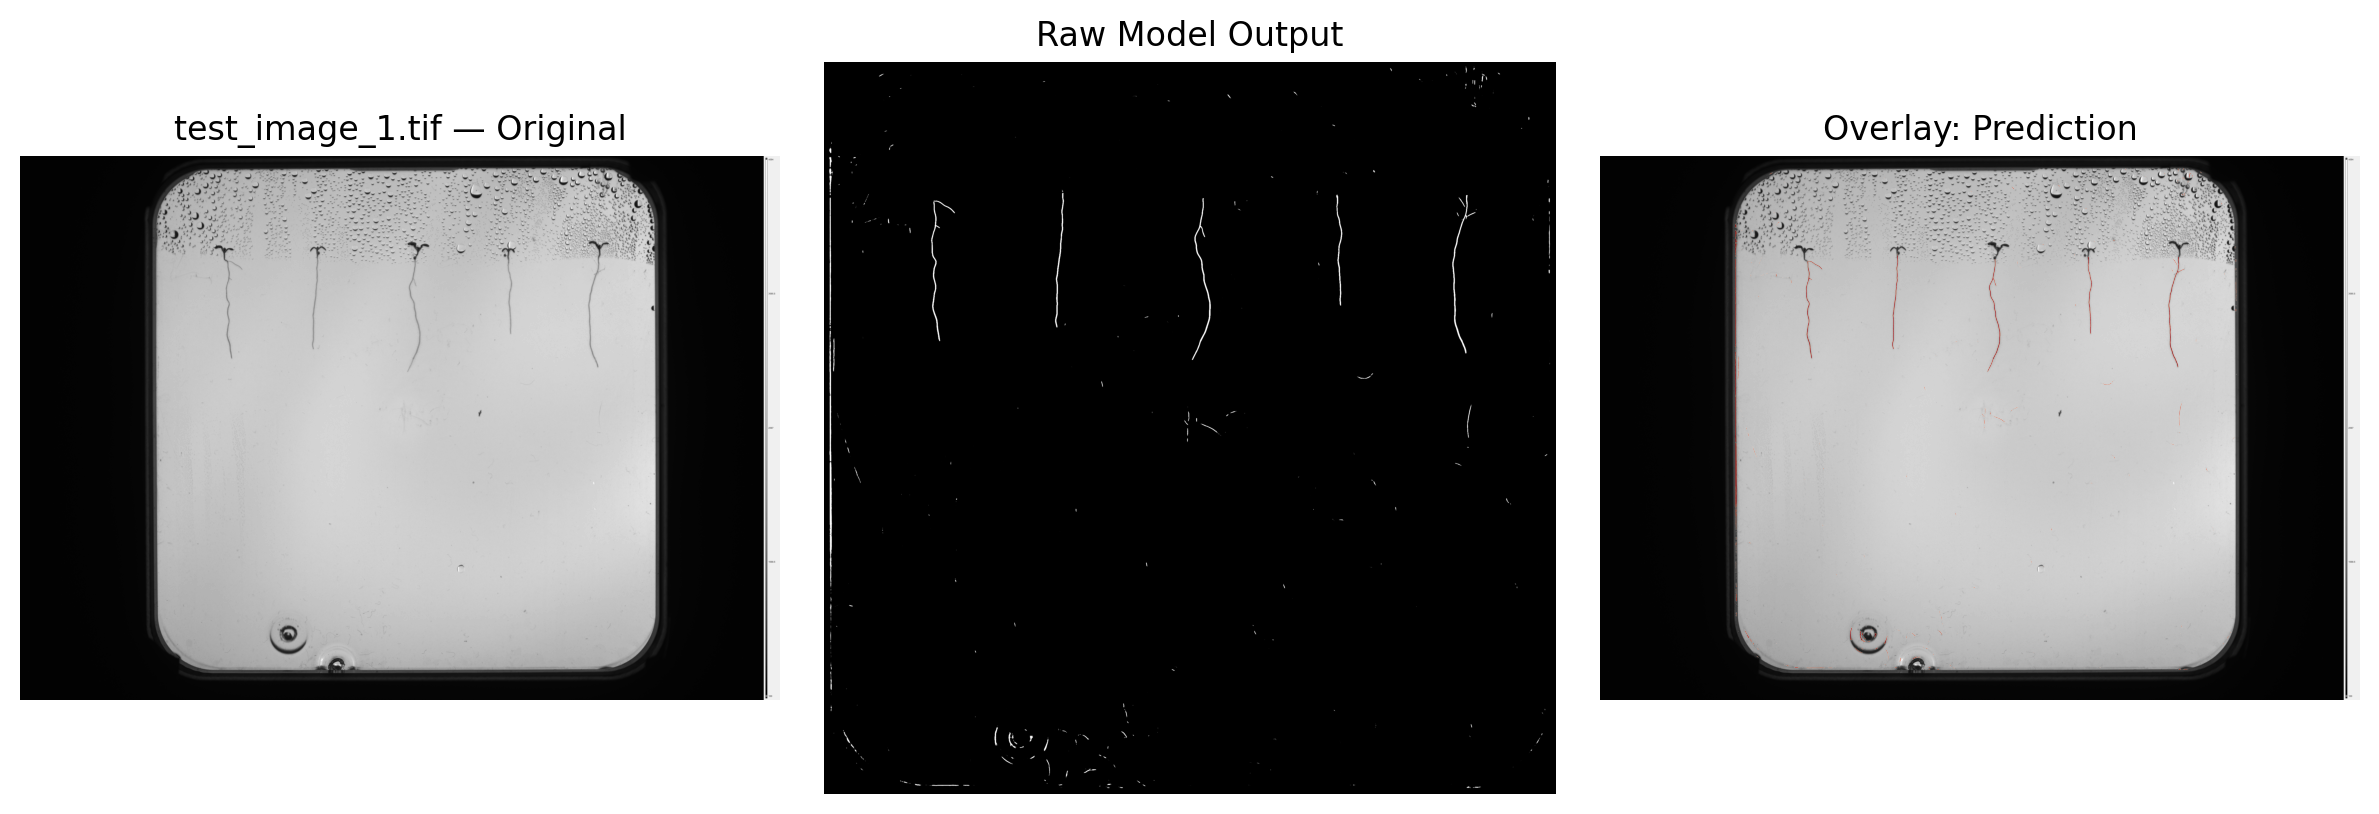


Processing test_image_10.tif


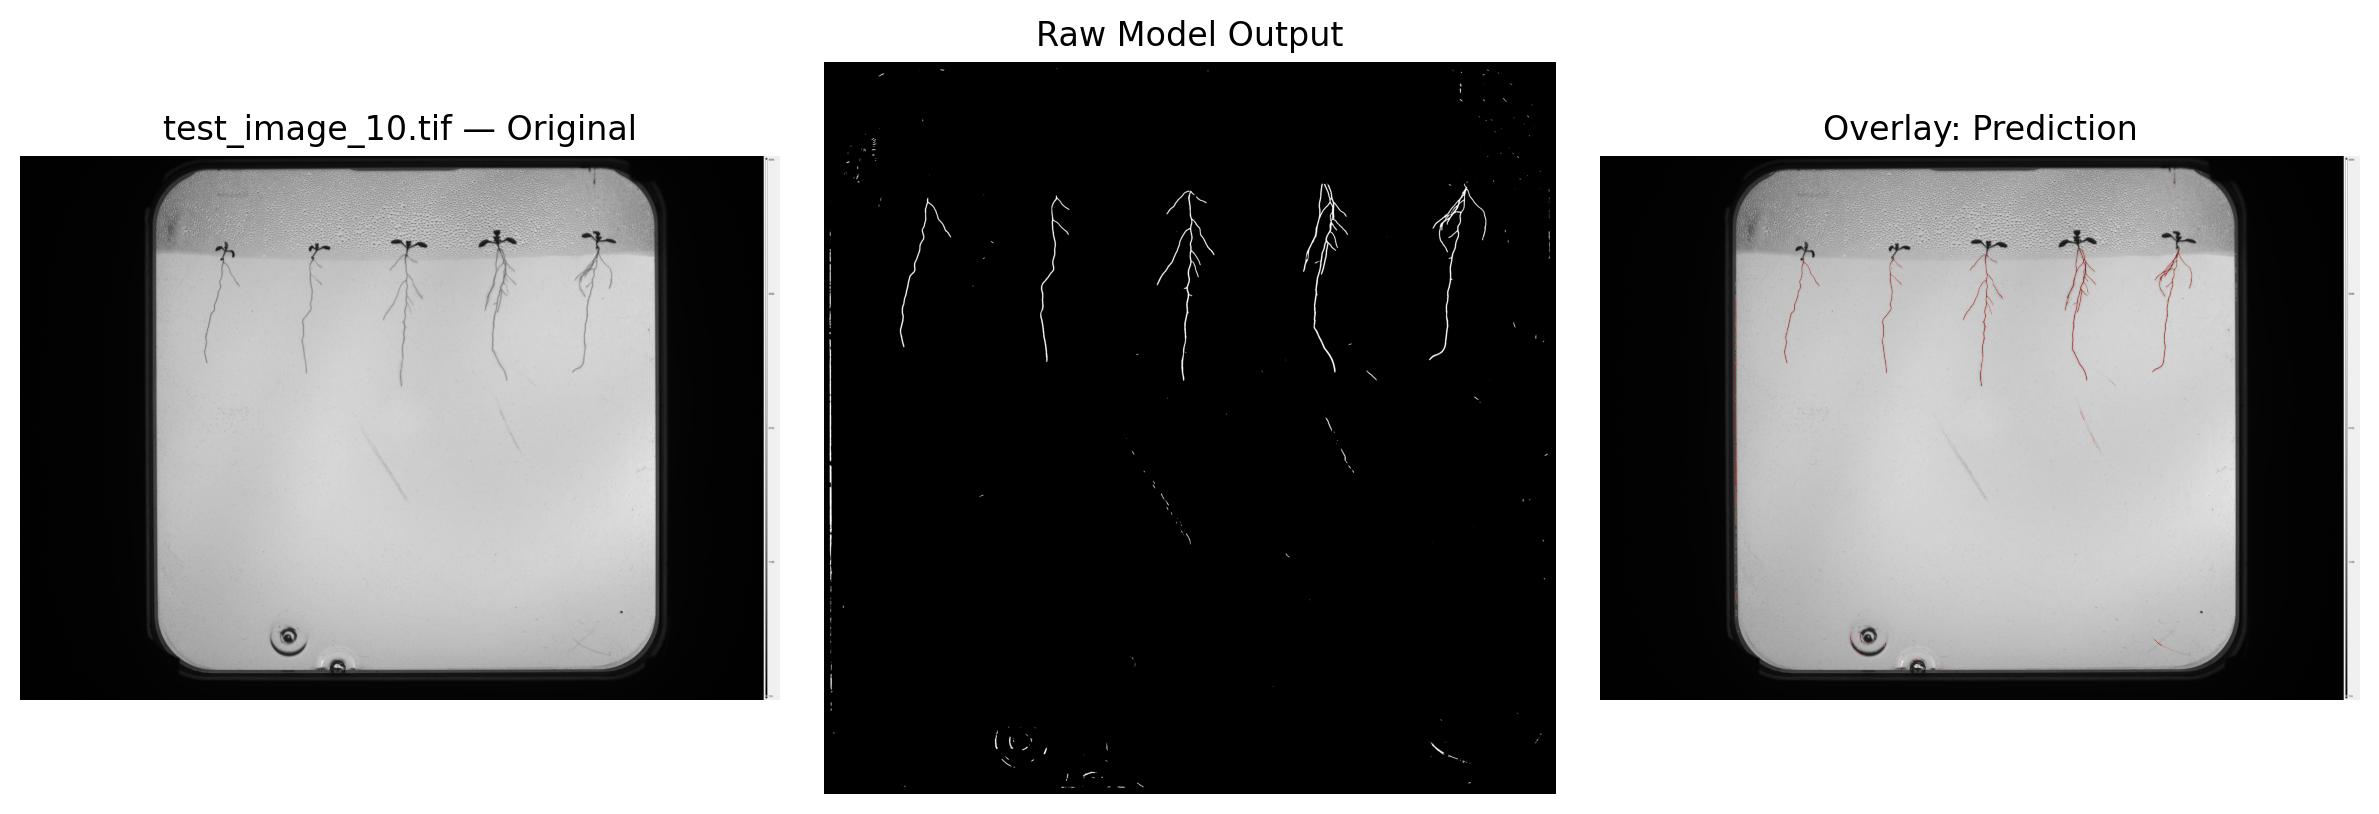


Processing test_image_11.tif


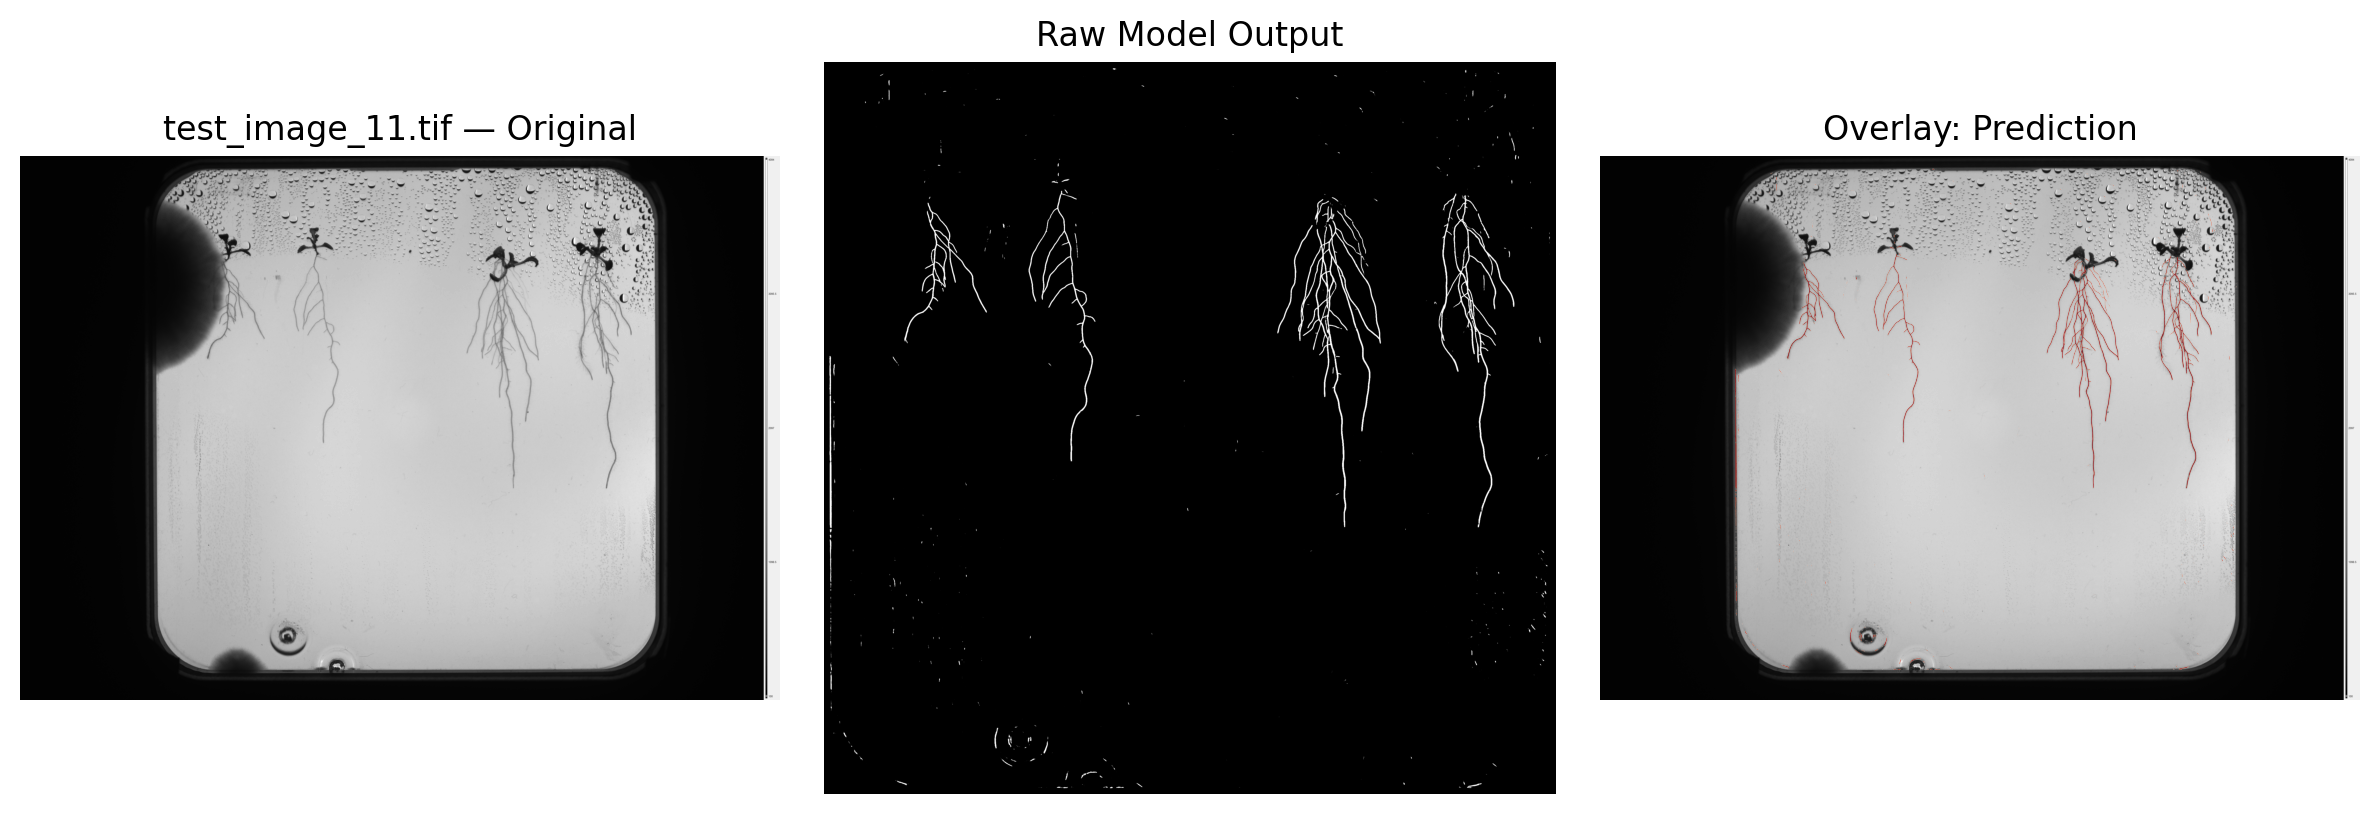


Processing test_image_2.tif


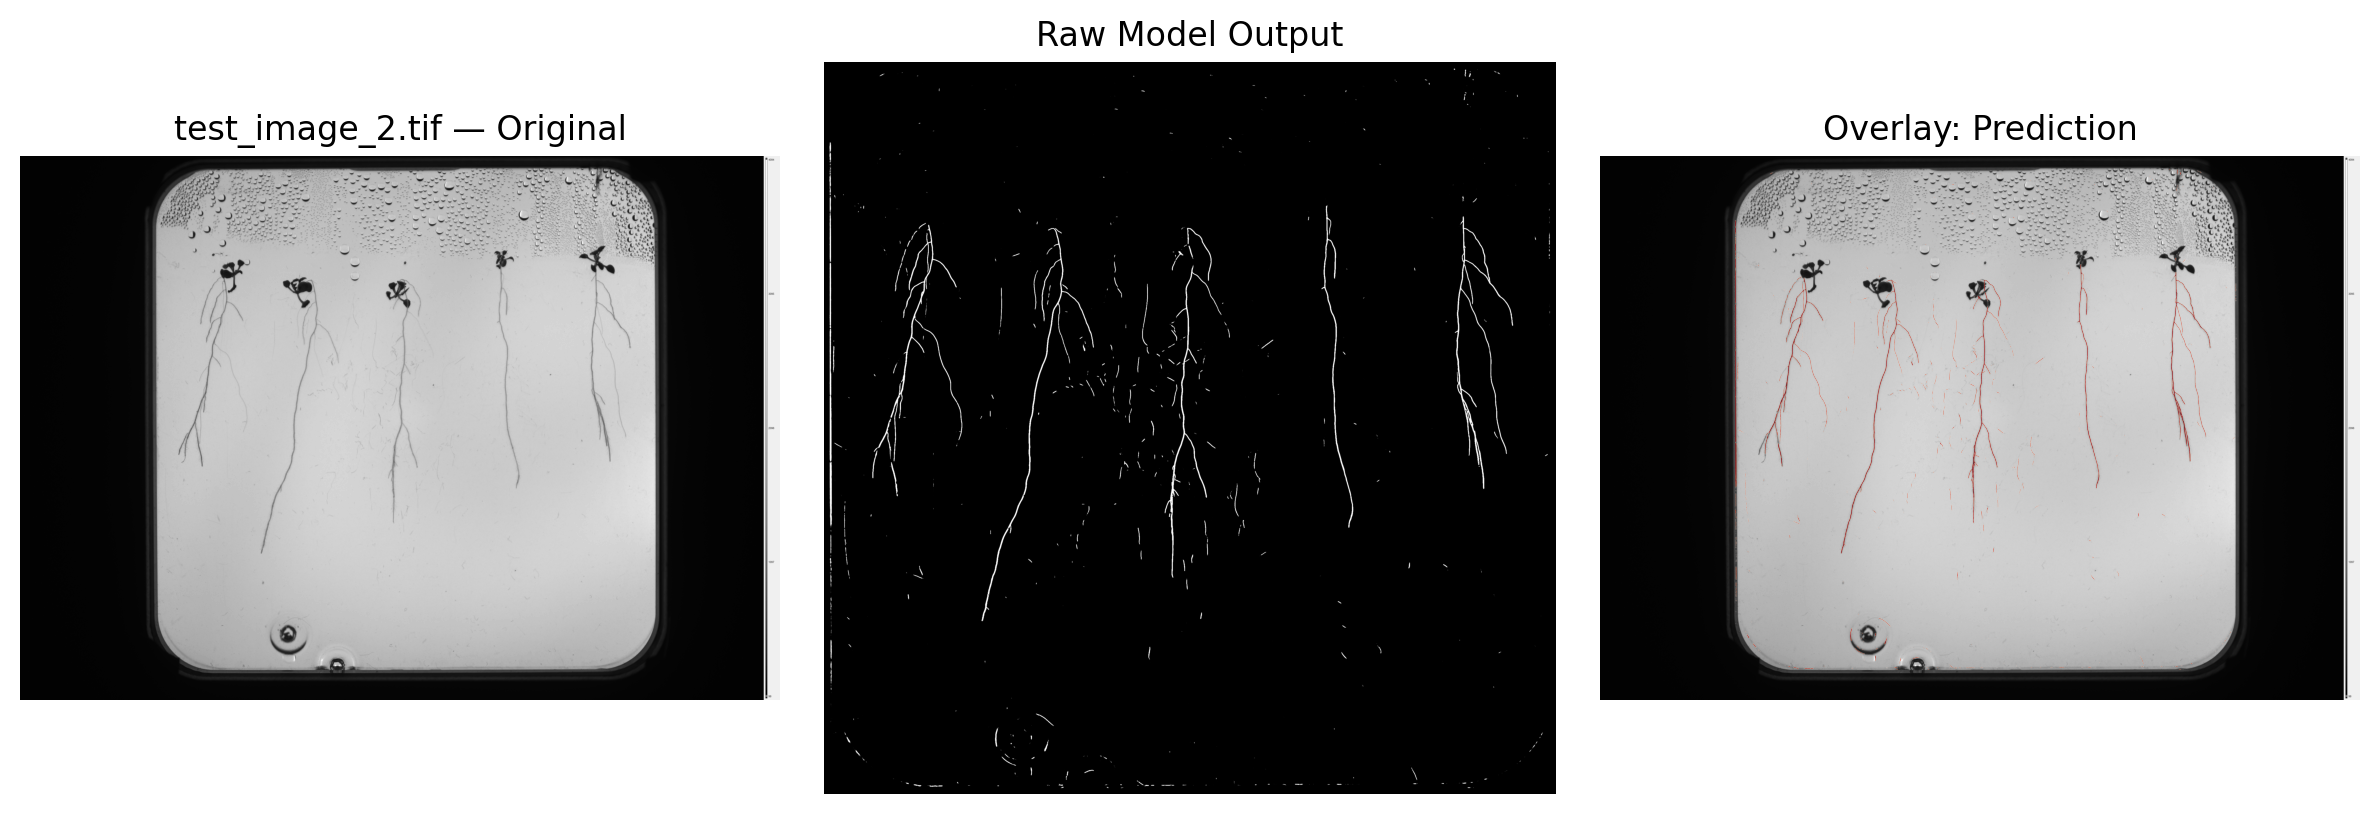


Processing test_image_3.tif


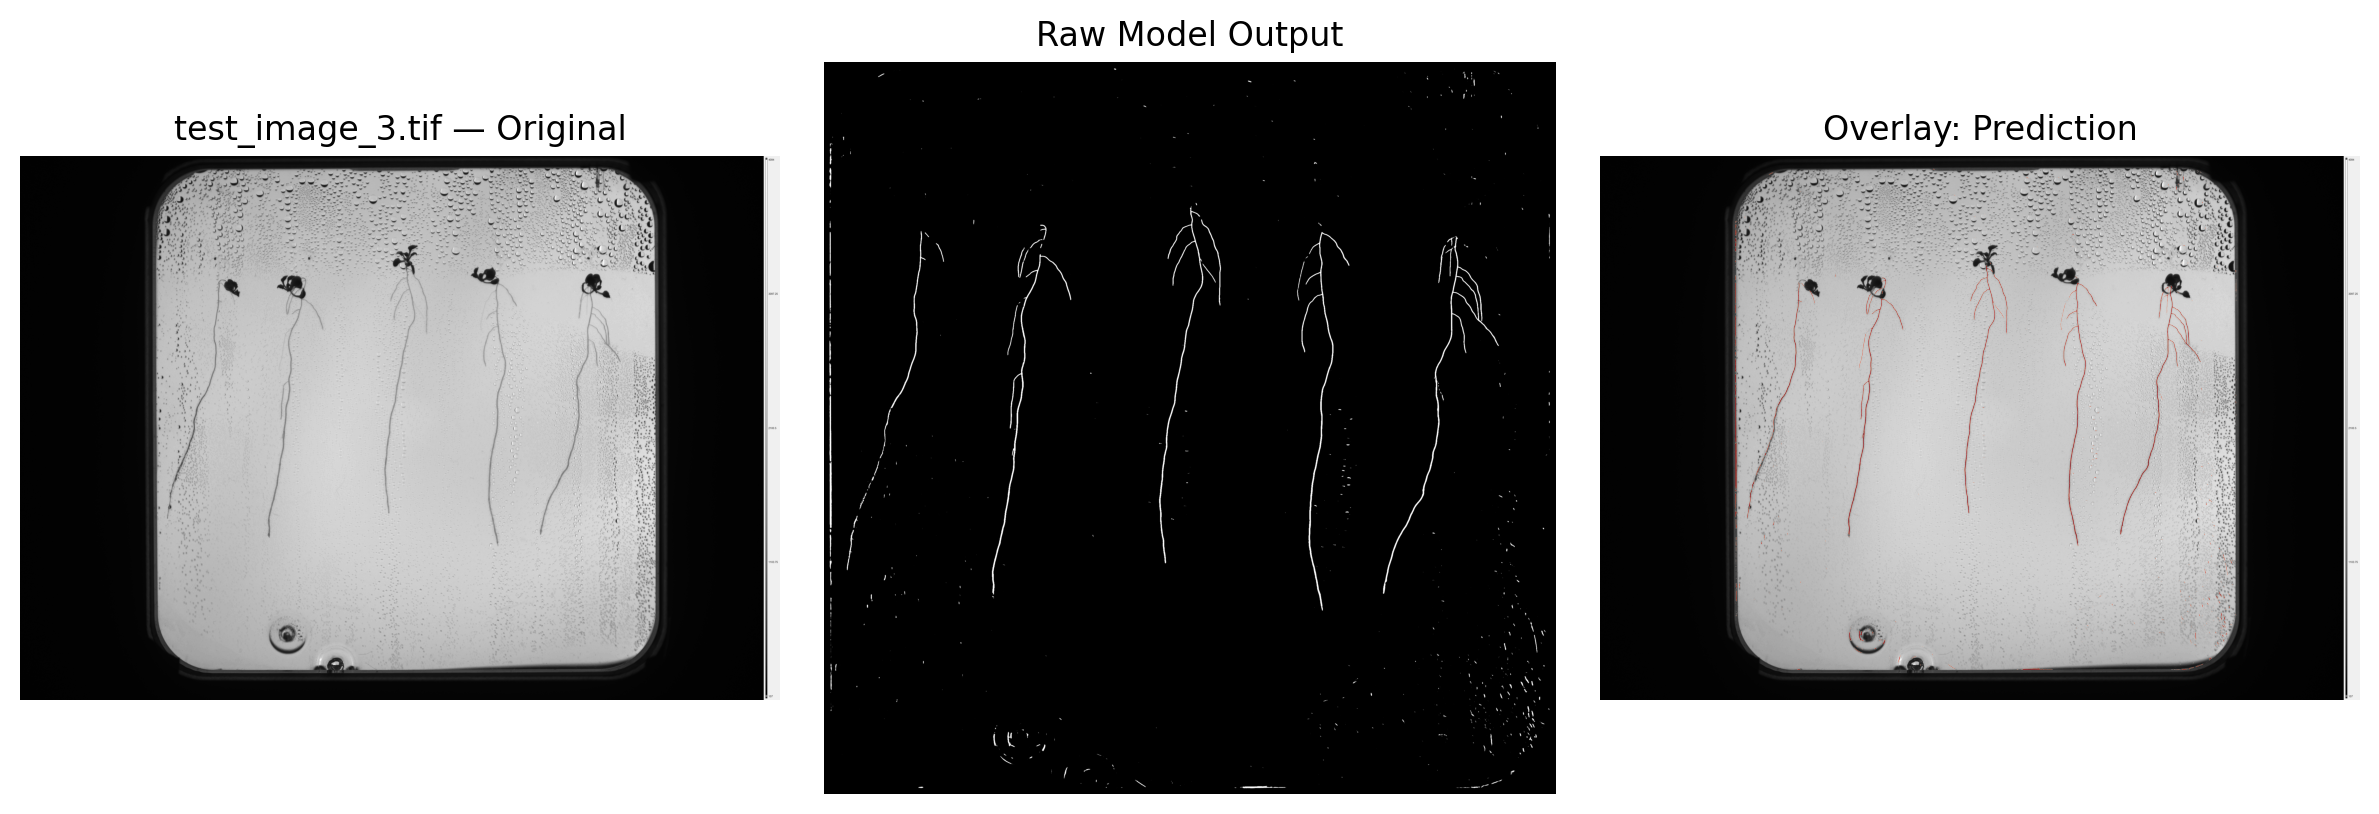


Processing test_image_4.tif


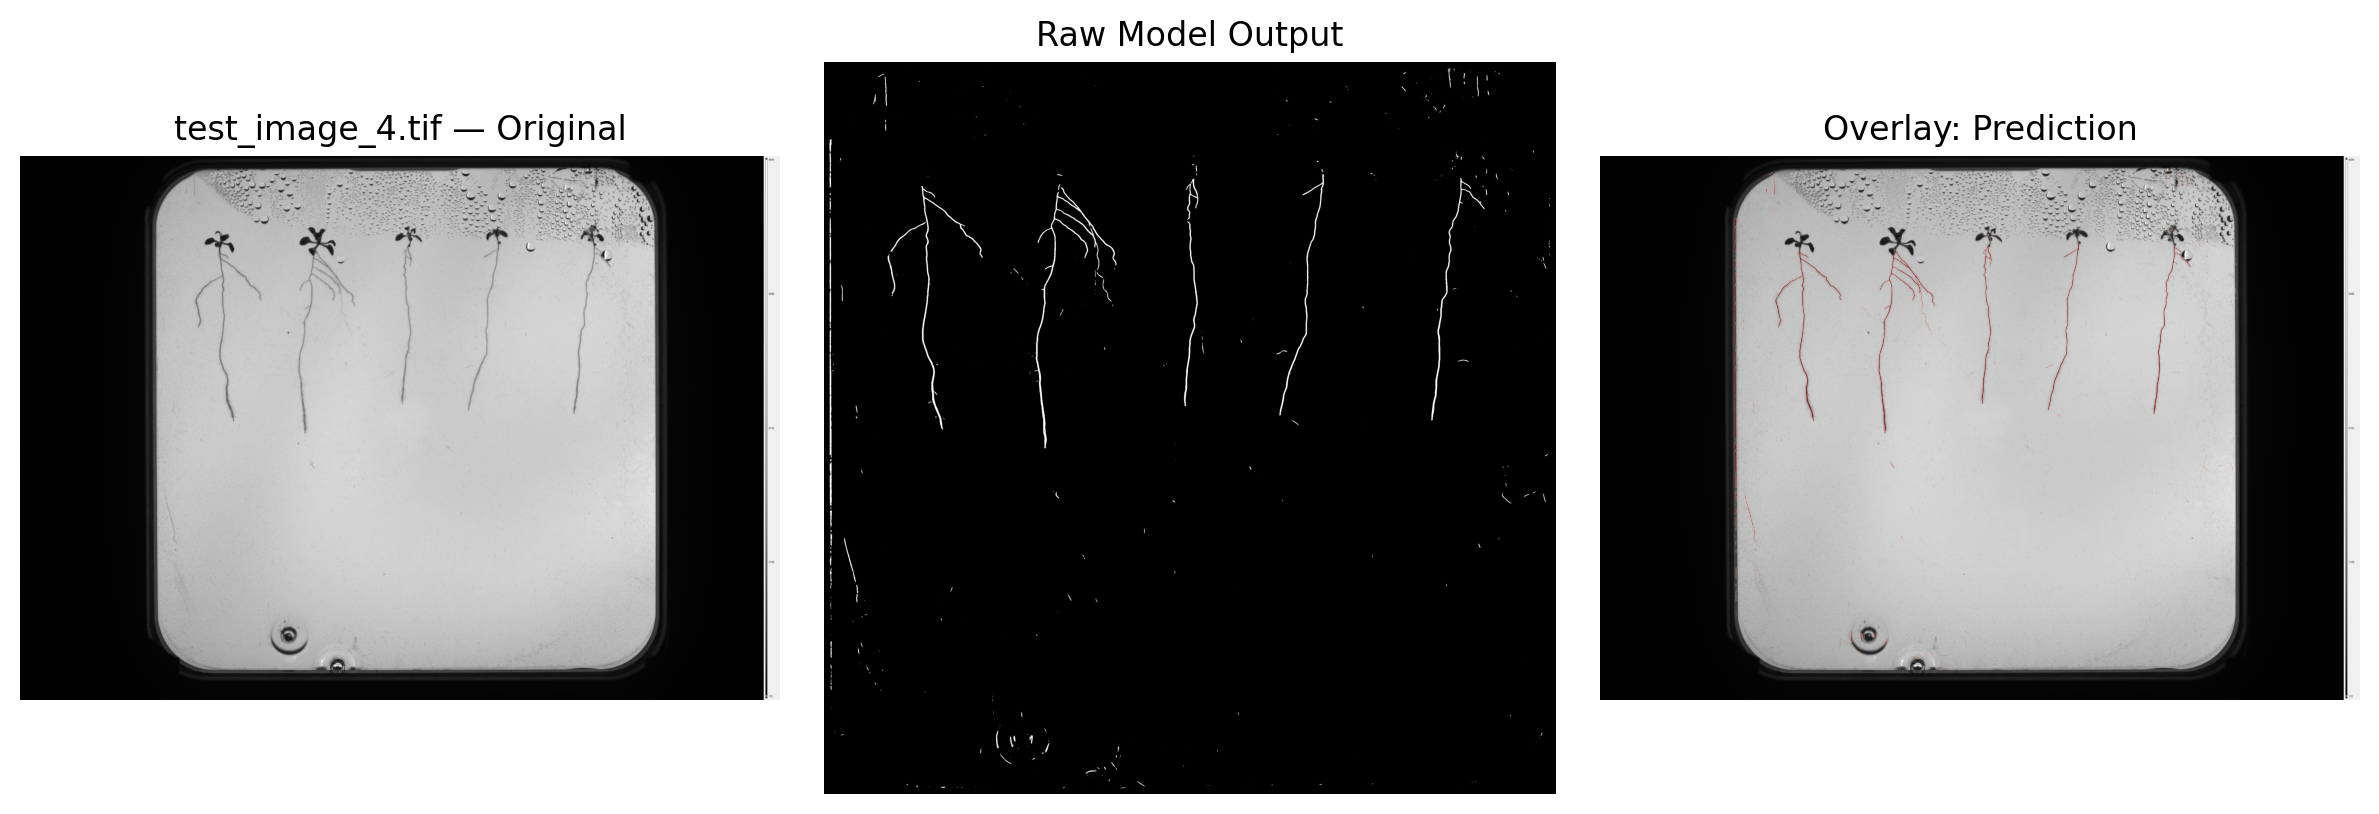


Processing test_image_5.tif


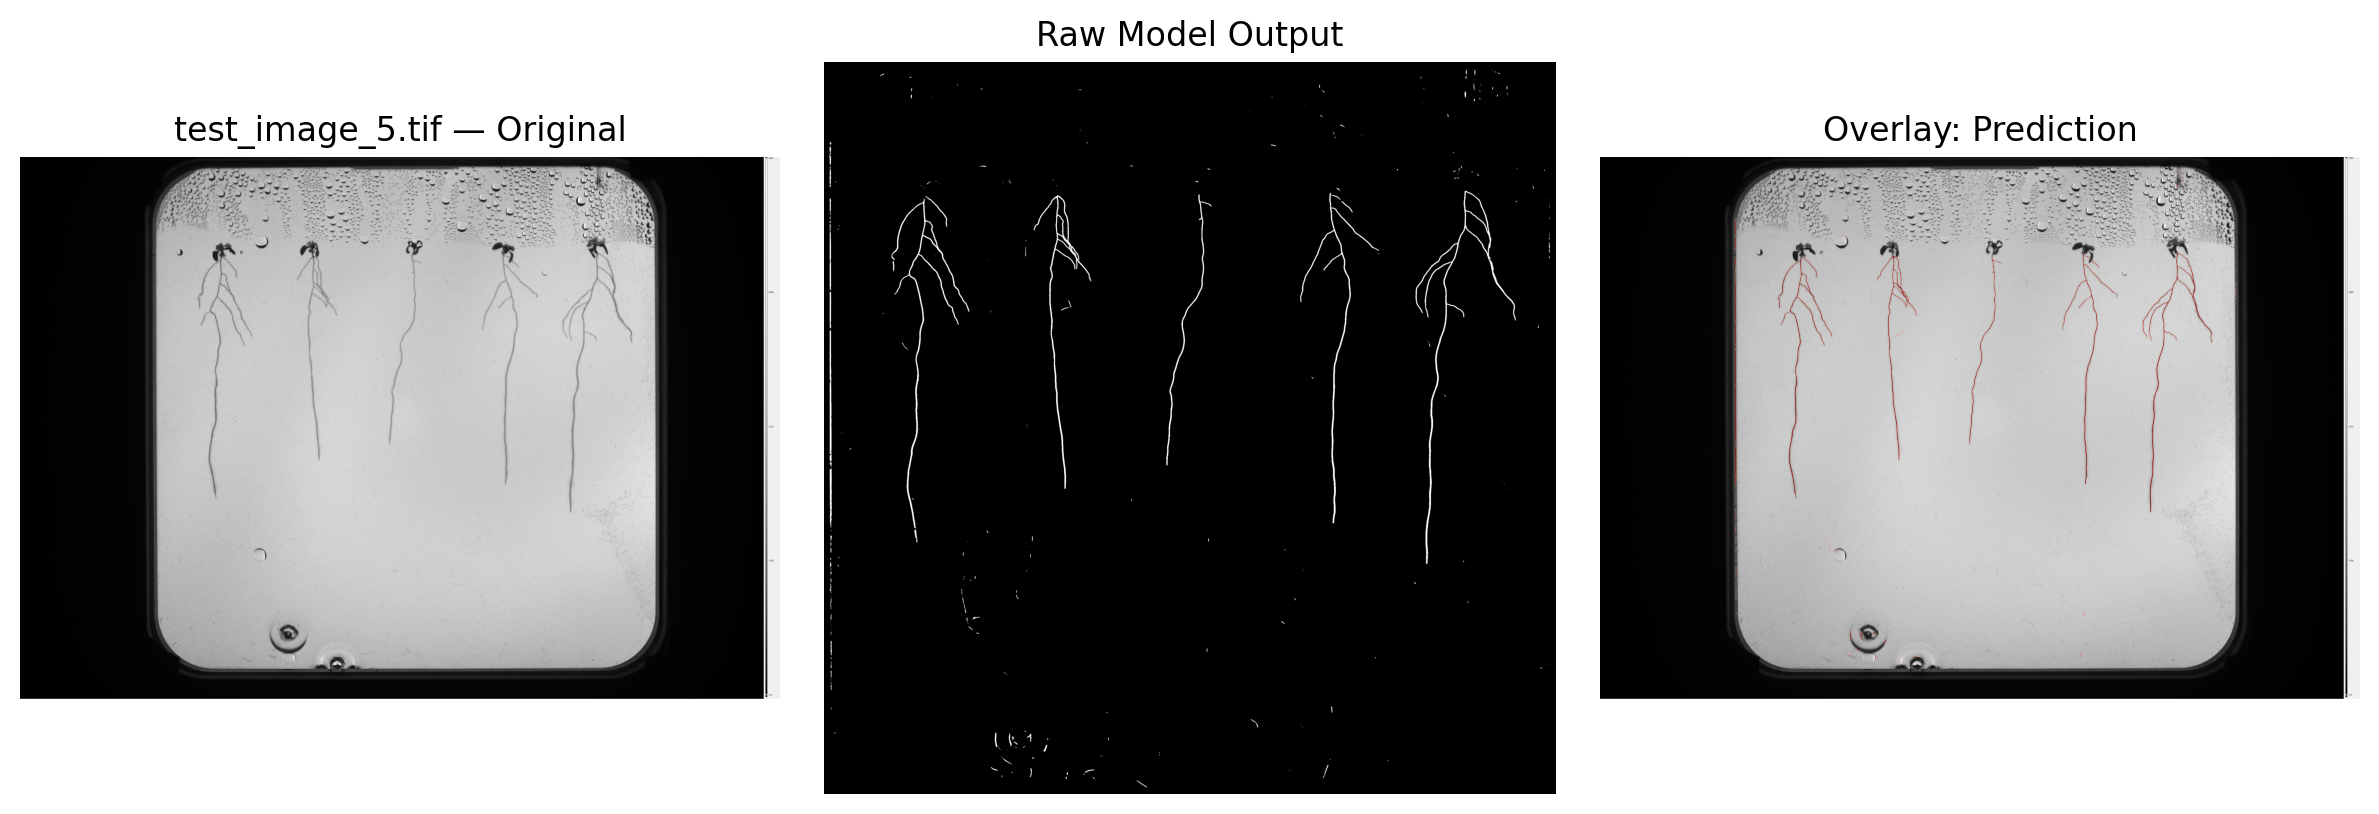


Processing test_image_6.tif


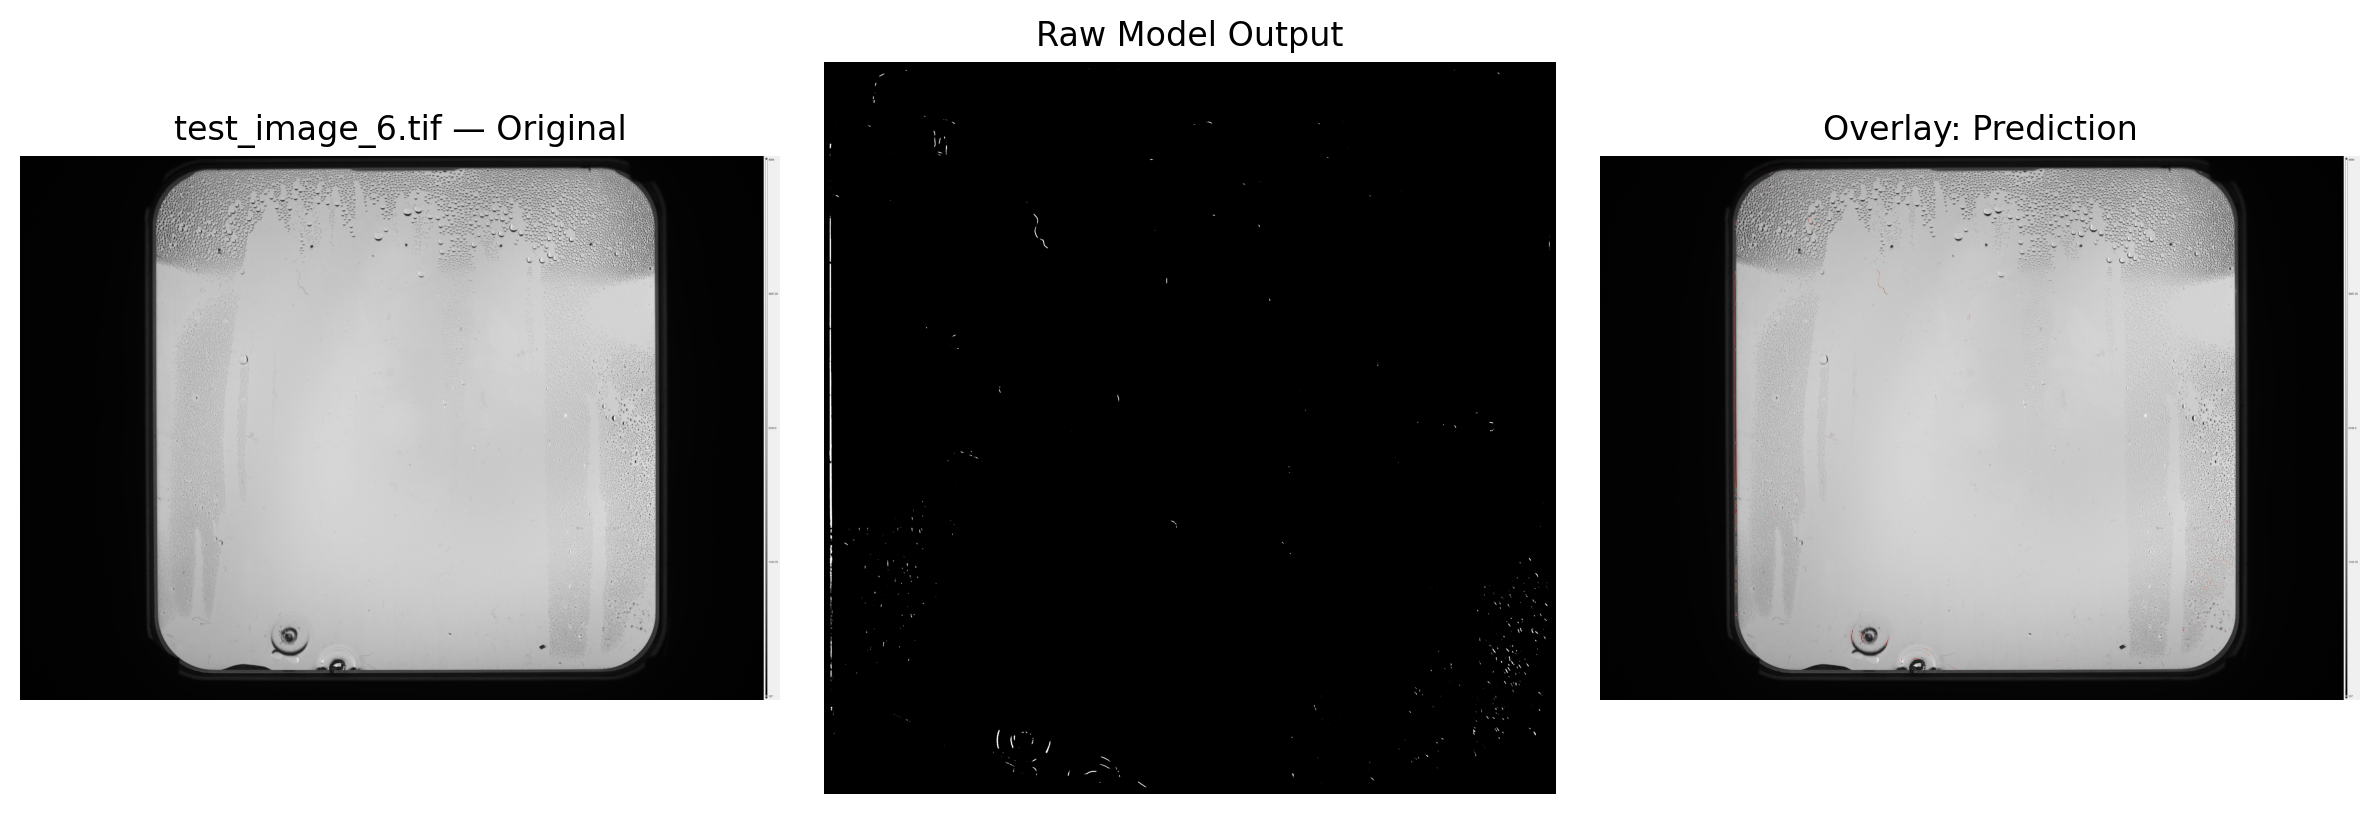


Processing test_image_7.tif


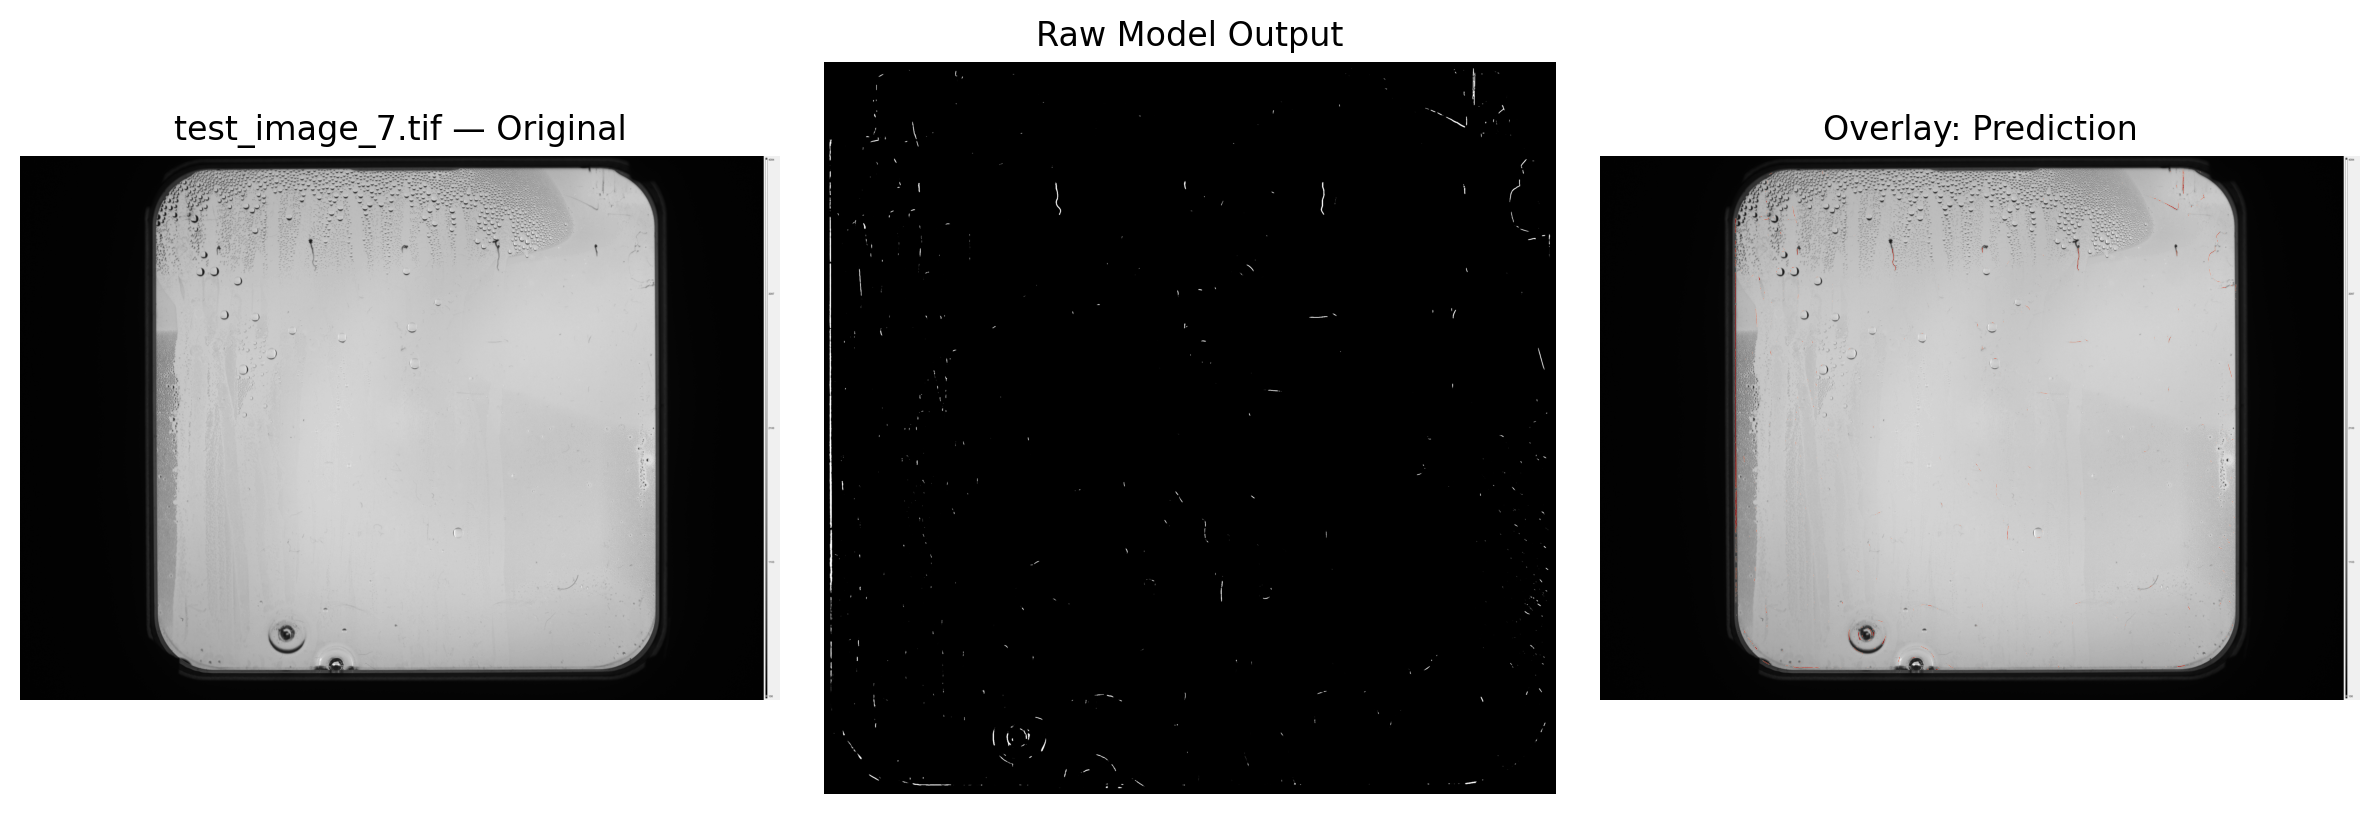


Processing test_image_8.tif


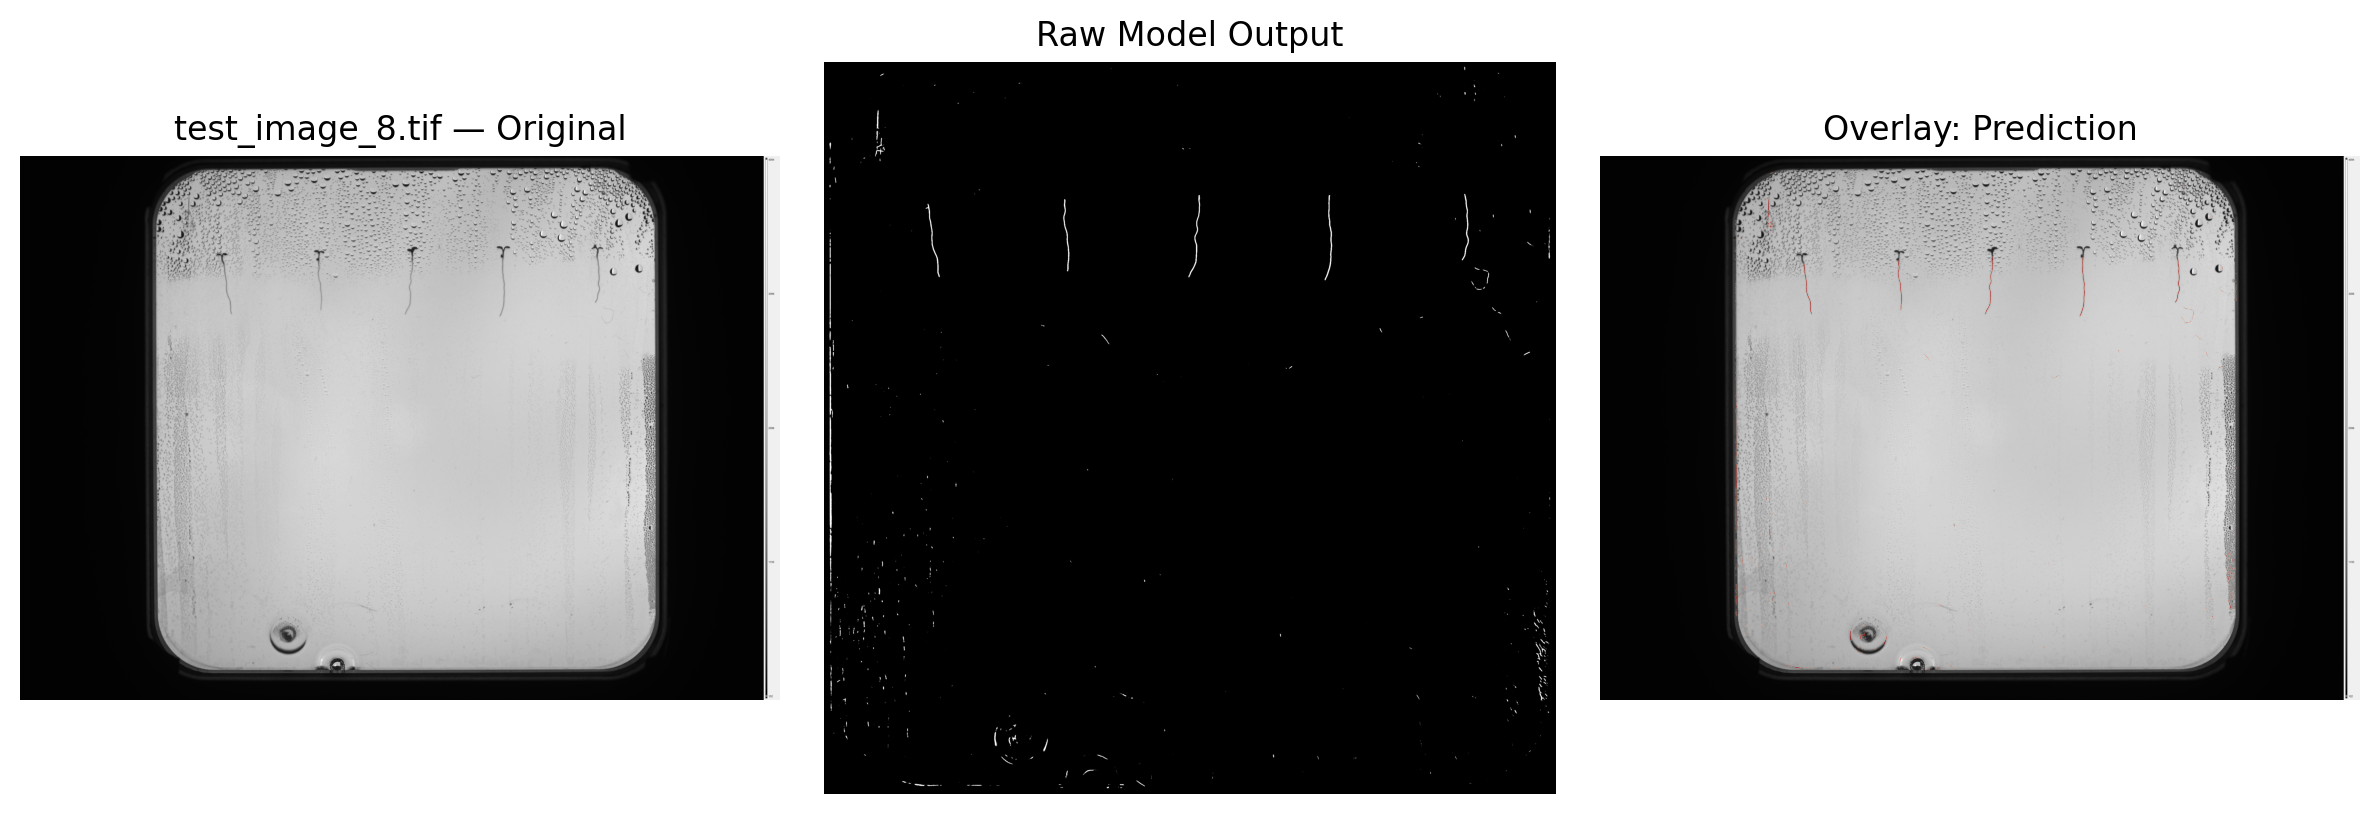


Processing test_image_9.tif


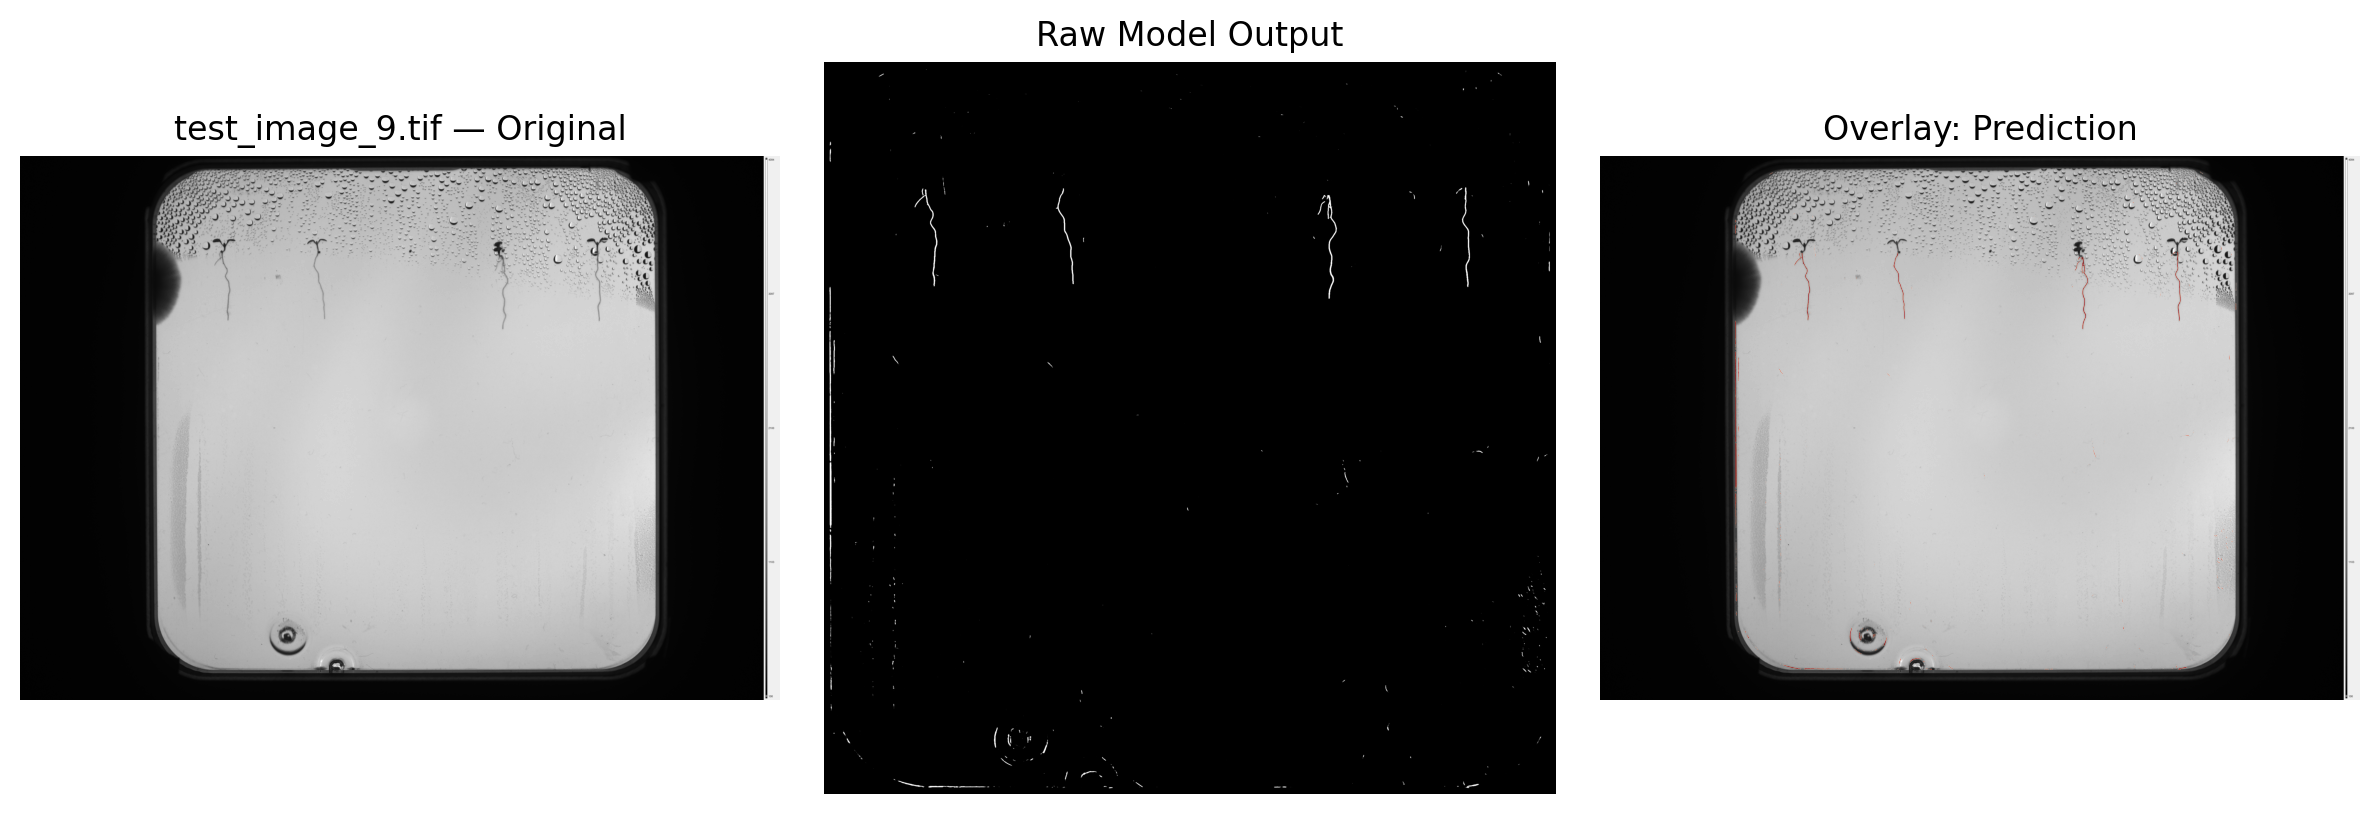

In [5]:
# Predict masks 

def predict_masks_raw(folder_path, model, patch_size=256):
    results = {}

    for filename in sorted(os.listdir(folder_path)):
        if not filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
            continue
        print(f"\nProcessing {filename}")
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path, 0)
        if image is None:
            continue

        # Preprocess, patchify, predict
        petri_dish, crop_info = cropper(image)
        petri_dish_padded, pad_info = padder(petri_dish, patch_size)

        patches = patchify(petri_dish_padded, (patch_size, patch_size), step=128)
        ph, pw = patches.shape[:2]
        patches_rgb = np.repeat(patches, 3, axis=-1)
        model_in = patches_rgb.reshape(-1, patch_size, patch_size, 3) / 255.0

        preds = model.predict(model_in, verbose=0)
        preds = preds.squeeze().reshape(ph, pw, patch_size, patch_size)
        mask_pred = unpatchify(preds, petri_dish_padded.shape)

        # Unpad & uncrop to original frame
        mask_unpad = unpadder(mask_pred, pad_info)
        mask_aligned = uncropper(mask_unpad, crop_info)

        results[filename] = {
            'mask': mask_aligned,
            'crop_info': crop_info,
            'pad_info': pad_info
        }

        # Visualization 
        f, ax = plt.subplots(1, 3, dpi=200, figsize=(12, 4))
        ax[0].imshow(image, cmap='gray'); ax[0].set_title(f"{filename} — Original"); ax[0].axis('off')
        ax[1].imshow(mask_pred, cmap='gray'); ax[1].set_title("Raw Model Output"); ax[1].axis('off')
        ax[2].imshow(image, cmap='gray')
        ax[2].imshow(mask_aligned, cmap='Reds', alpha=(mask_aligned > 0.1) * 0.6)
        ax[2].set_title("Overlay: Prediction"); ax[2].axis('off')
        plt.tight_layout(); plt.show()

    return results
# Run segmentation inference
raw_predictions = predict_masks_raw(test_folder, model, patch_size)


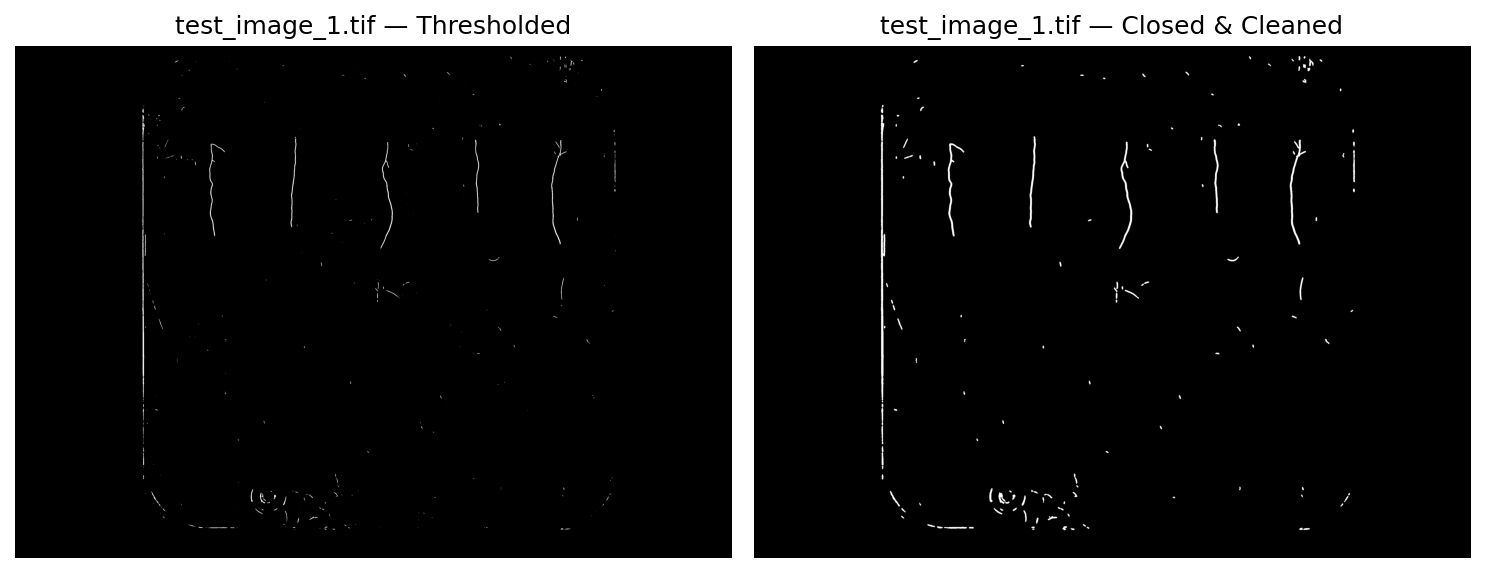

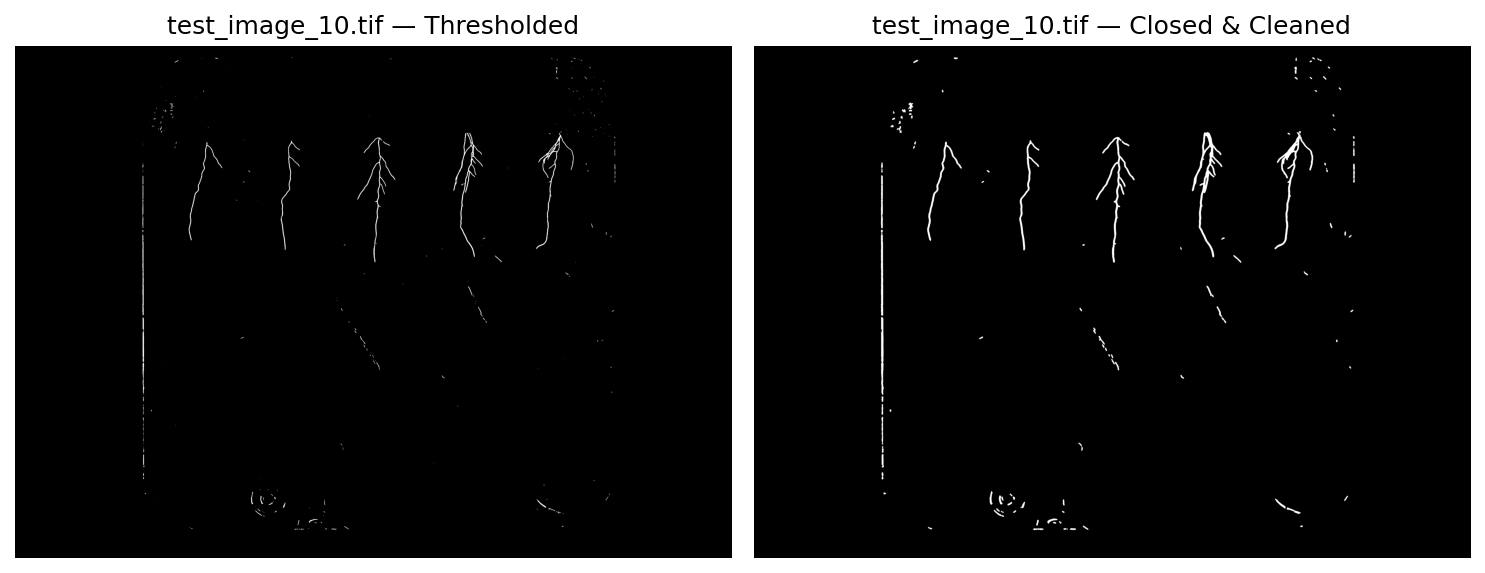

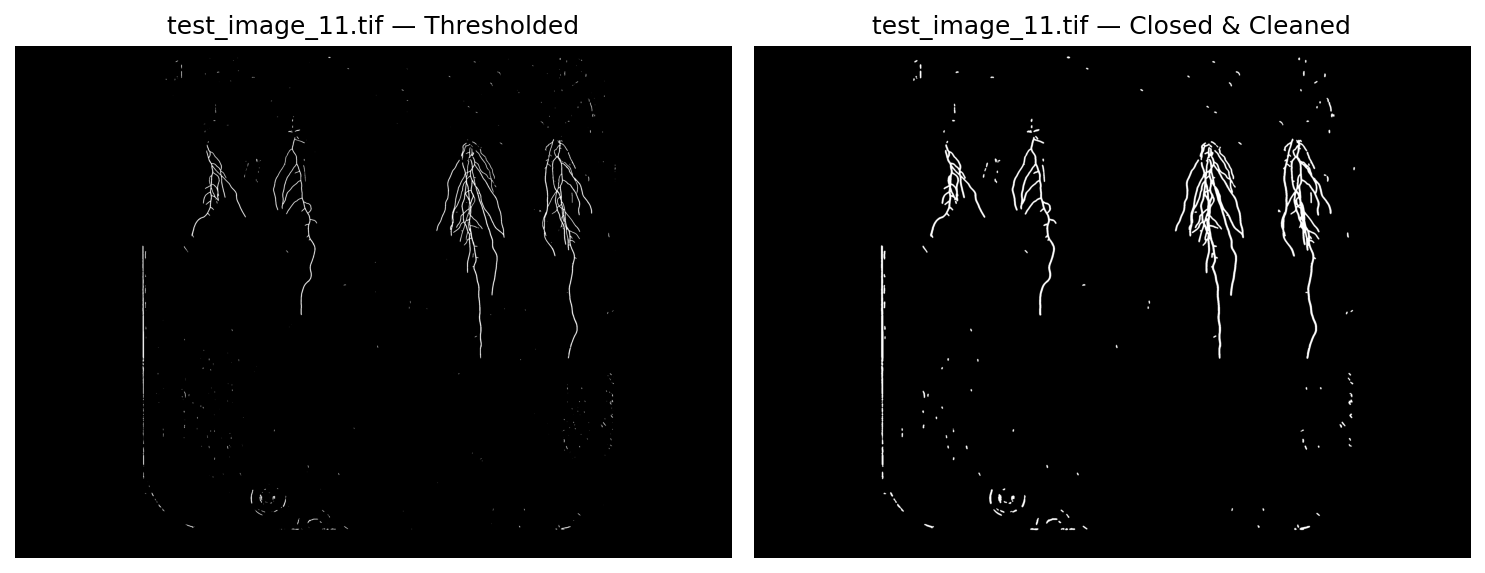

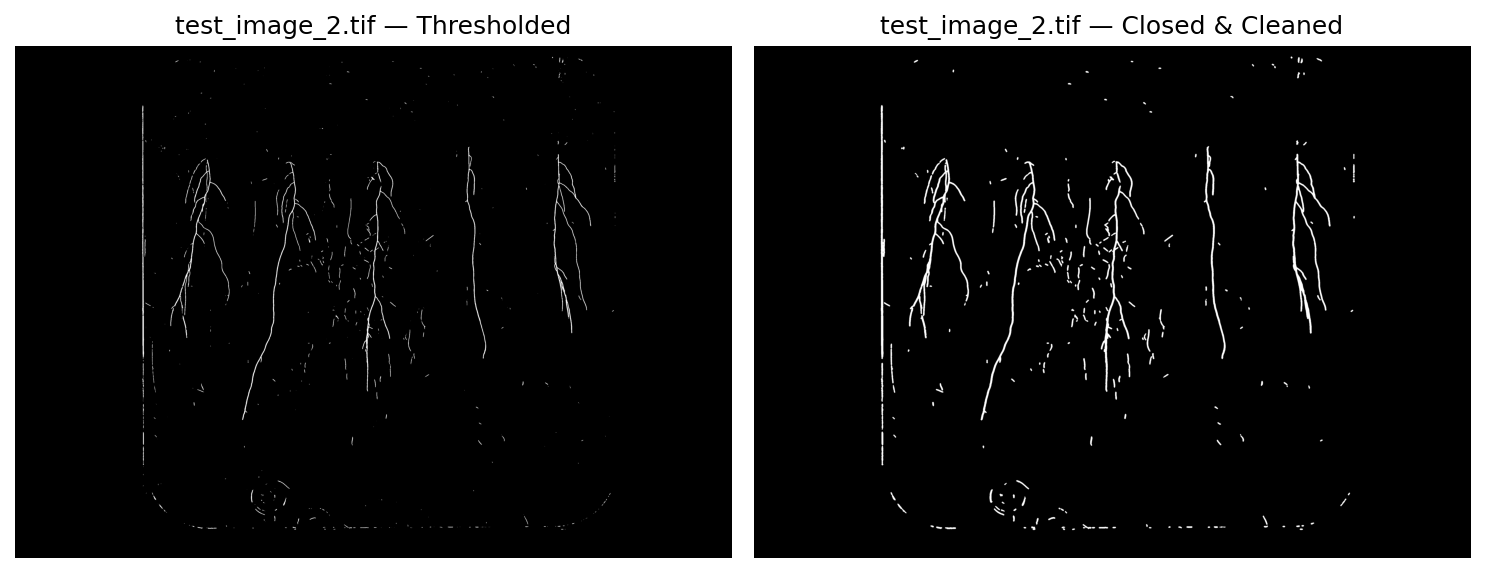

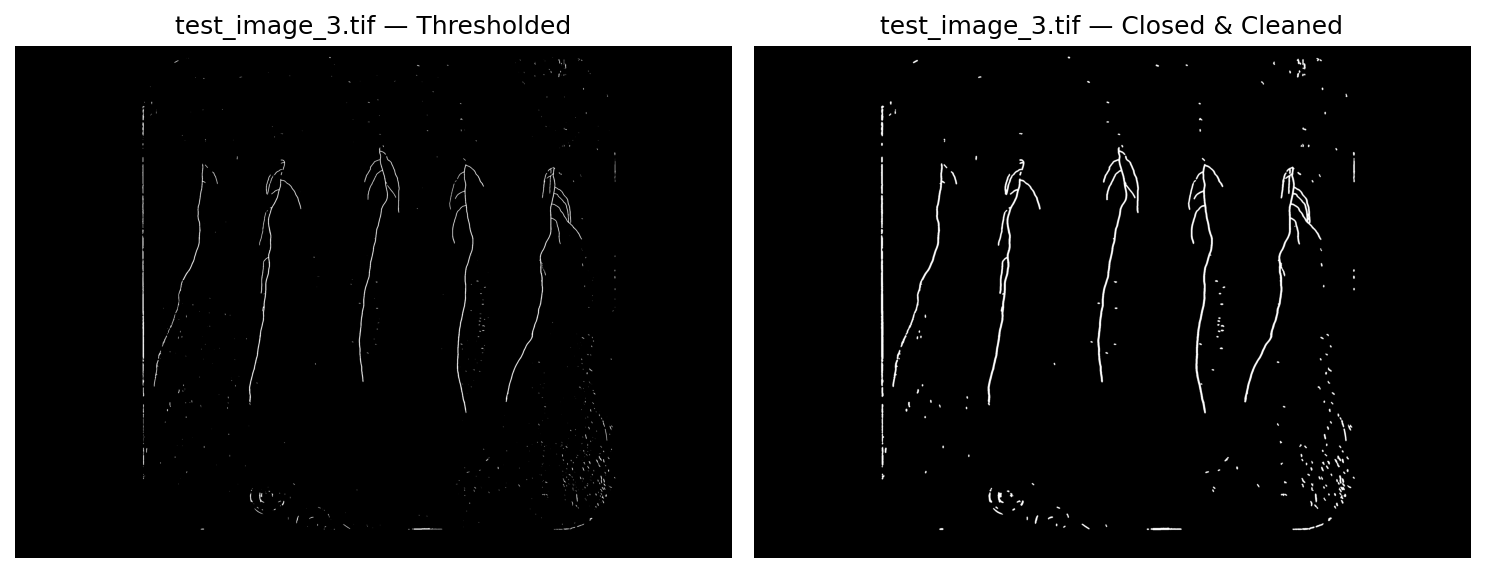

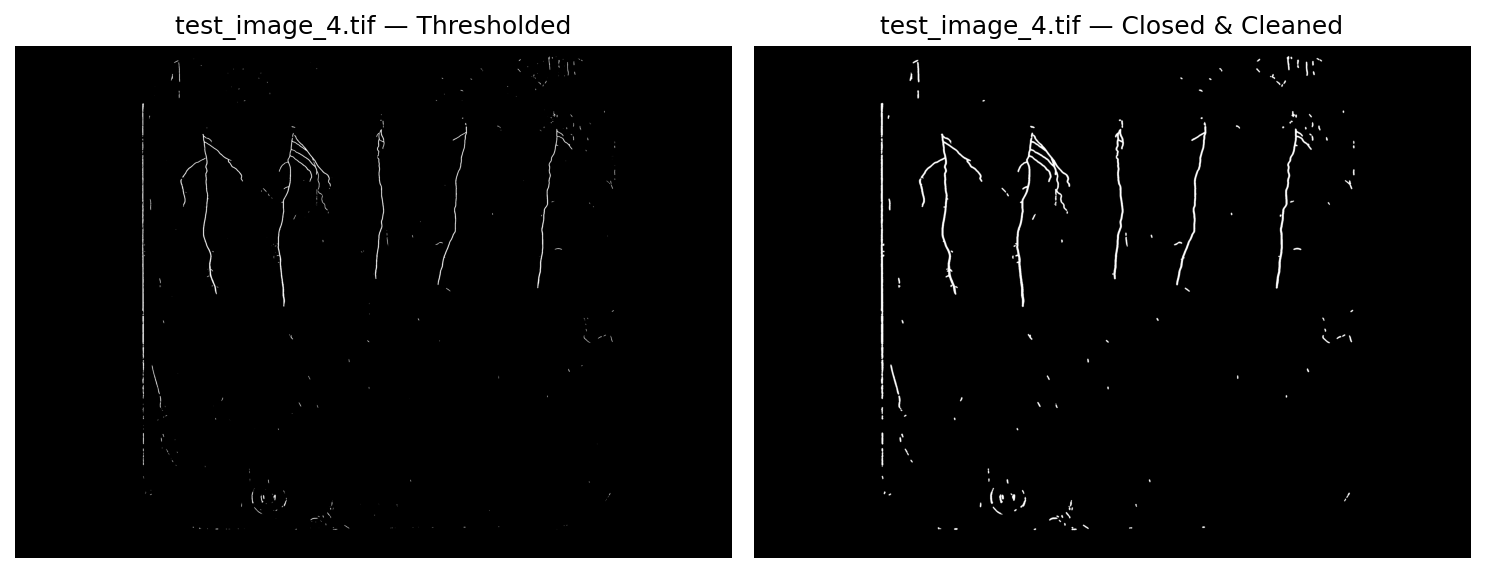

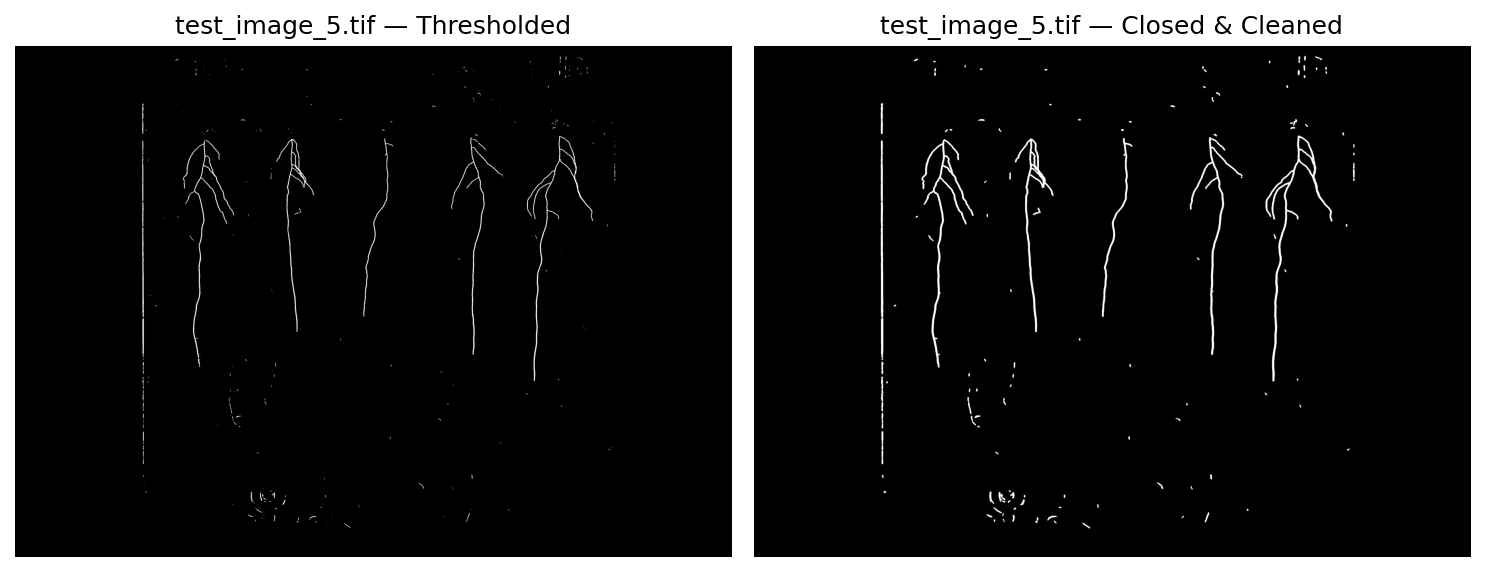

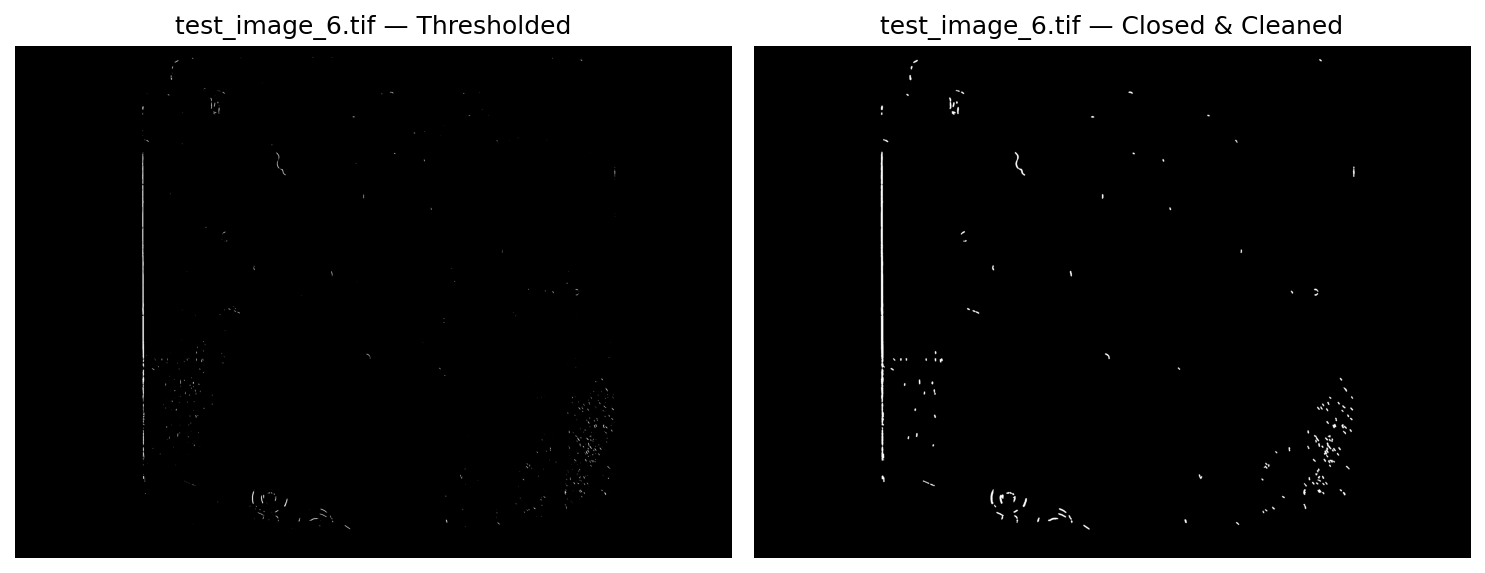

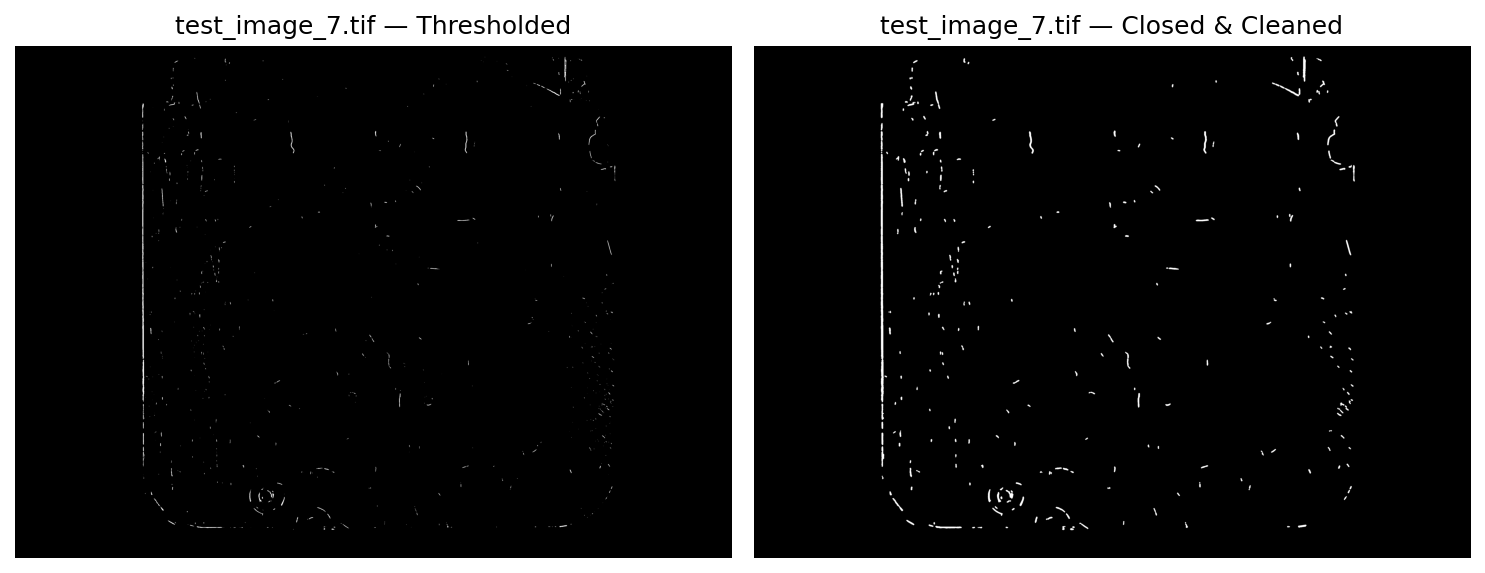

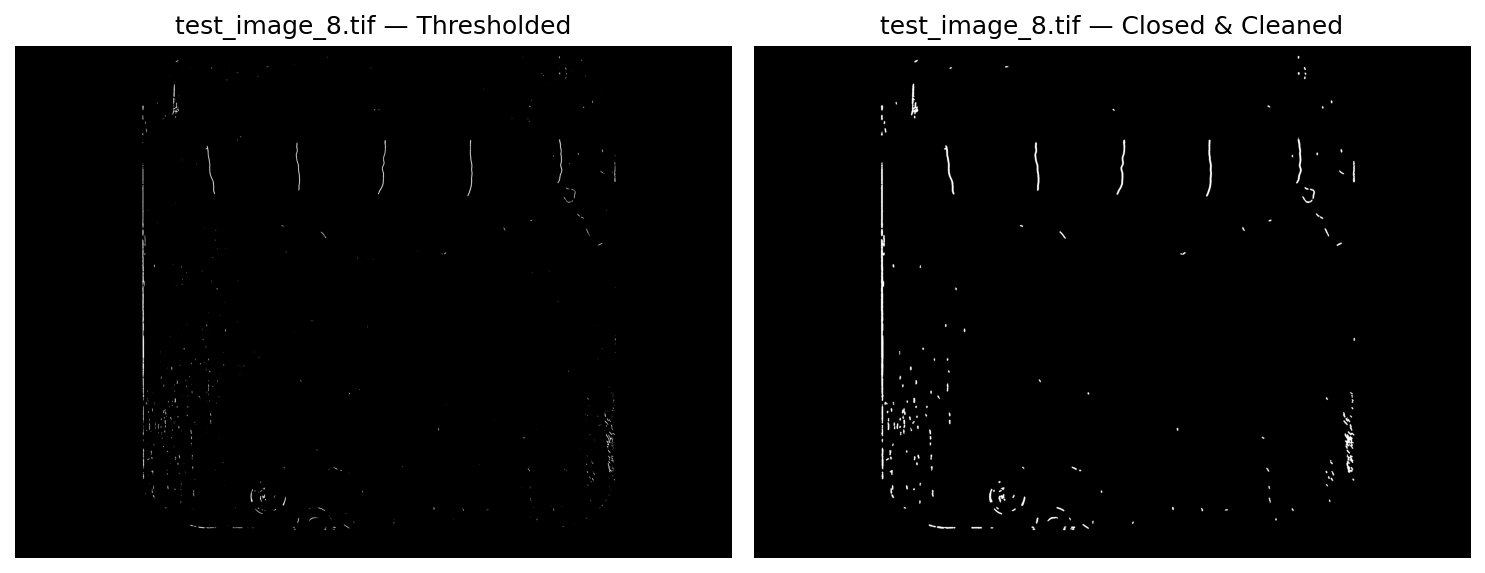

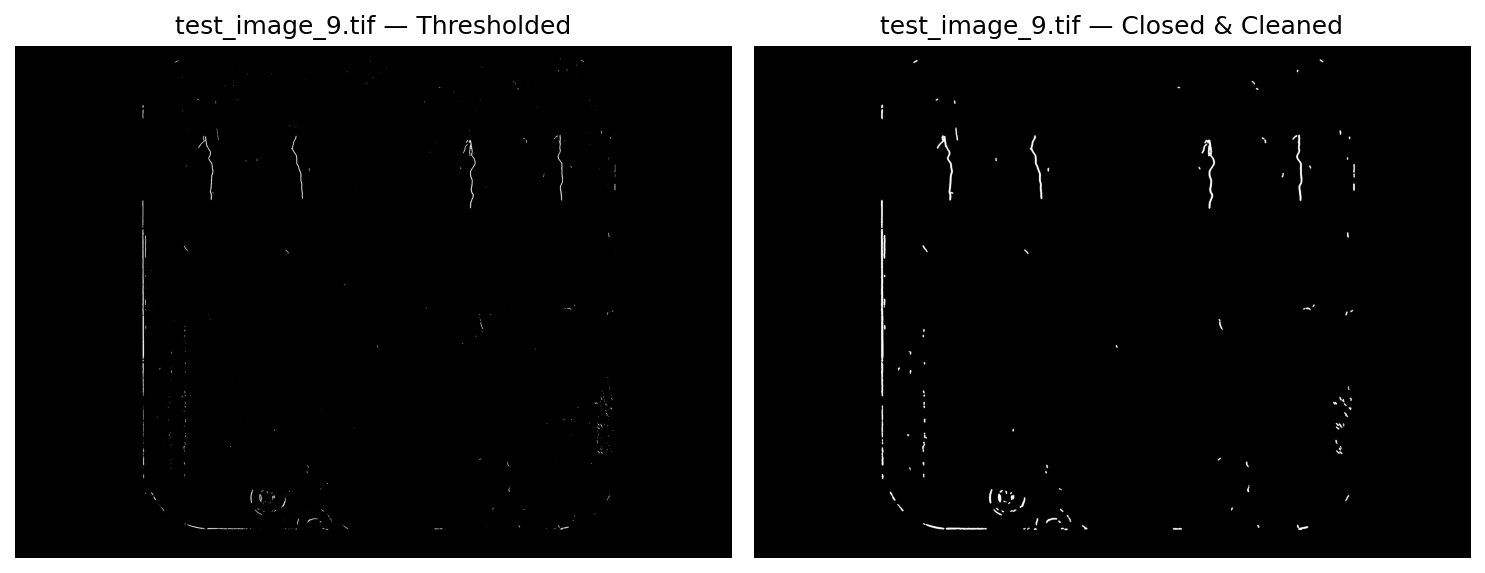

In [6]:

# Threshold + Morphological Closing + small-blob cleanup
thresholded_masks = {
    name: (raw['mask'] > threshold).astype(np.uint8)
    for name, raw in raw_predictions.items()
}

closed_masks = {}
kernel = cv2.getStructuringElement(kernel_shape, kernel_size)

for name, binary in thresholded_masks.items():
    base = binary.copy()

    # Closing
    dilated = cv2.dilate(base, kernel, iterations=dilate_iterations)
    closed  = cv2.erode(dilated, kernel, iterations=erode_iterations)

    # Remove tiny blobs (<100 px)
    min_blob_area = 100
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(closed)
    clean = np.zeros_like(closed)
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] >= min_blob_area:
            clean[labels == i] = 1

    closed_masks[name] = clean

    # Visualization 
    fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
    axs[0].imshow(base * 255, cmap='gray');  axs[0].set_title(f'{name} — Thresholded');        axs[0].axis('off')
    axs[1].imshow(clean * 255, cmap='gray'); axs[1].set_title(f'{name} — Closed & Cleaned');   axs[1].axis('off')
    plt.tight_layout(); plt.show()


In [7]:
# Crop top region and horizontally to dish bounds
dish_cropped_masks = {}
for name, closed in closed_masks.items():
    crop_info = raw_predictions[name]['crop_info']
    x_start = crop_info['x_start']
    crop_size = crop_info['crop_size']
    x_end = min(x_start + crop_size, closed.shape[1])

    horiz = closed[:, x_start:x_end]
    h = horiz.shape[0]
    top_crop = int(h * top_crop_ratio)
    final_cropped = horiz[top_crop:, :]

    dish_cropped_masks[name] = final_cropped


In [8]:

# Segment likely primary root per plant band
segmented_root_masks = {}
for name, mask in dish_cropped_masks.items():
    h, w = mask.shape
    band_width = w / num_plants

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)
    plant_masks = [np.zeros_like(mask, dtype=np.uint8) for _ in range(num_plants)]

    for i in range(1, num_labels): 
        x, y, cw, ch, area = stats[i]
        cx = centroids[i][0]

        if area < min_area:
            continue
        if area < margin_area_thresh and (x + cw > w - margin or x < margin):
            continue
        ar = ch / cw if cw > 0 else 0
        if ar < aspect_ratio_threshold:
            continue
        if y > int(h * vertical_start_thresh_ratio):
            continue

        band_idx = min(int(cx // band_width), num_plants - 1)
        comp = (labels == i).astype(np.uint8)

        if np.count_nonzero(plant_masks[band_idx]) < area:
            plant_masks[band_idx] = comp

    plant_masks = [(m * 255).astype(np.uint8) for m in plant_masks]
    segmented_root_masks[name] = plant_masks

# Flatten 
final_root_masks = {}
for name, plant_masks in segmented_root_masks.items():
    base_name = os.path.splitext(name)[0]
    for idx, m in enumerate(plant_masks):
        key = f"{base_name}_plant_{idx + 1}"
        final_root_masks[key] = m


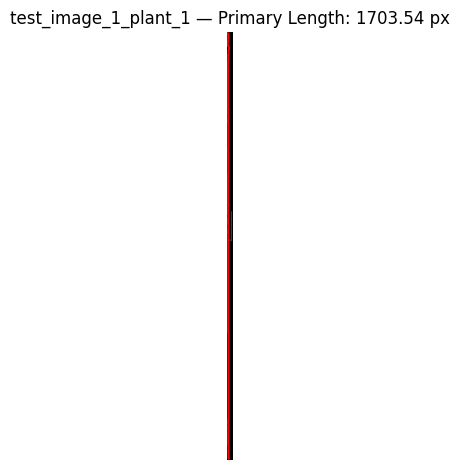

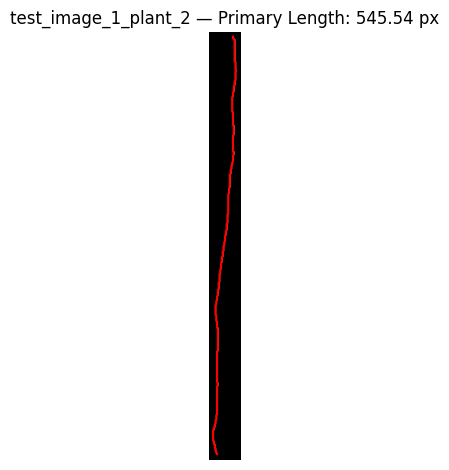

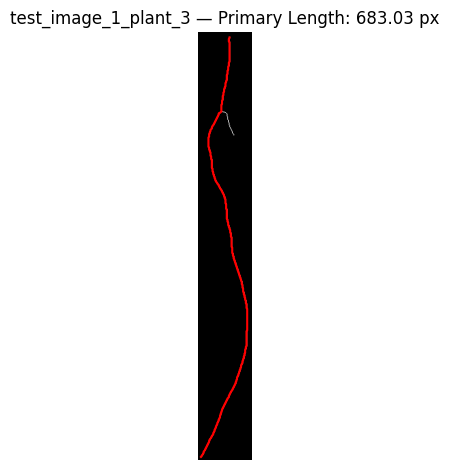

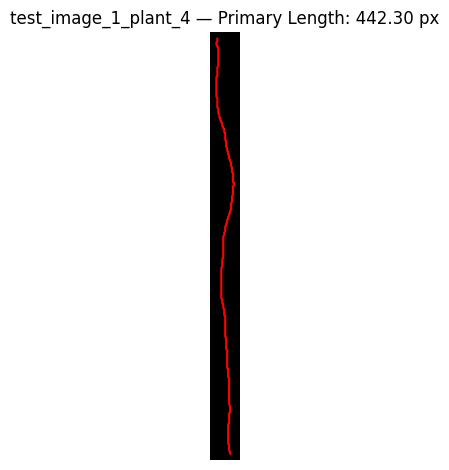

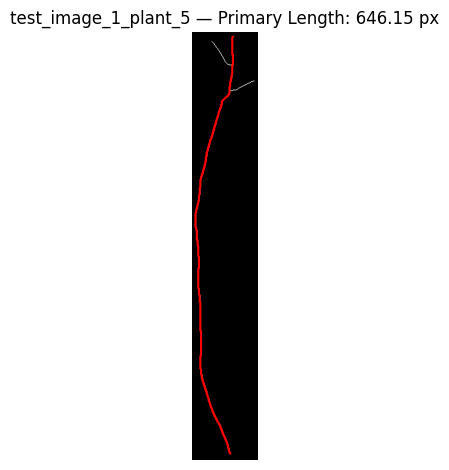

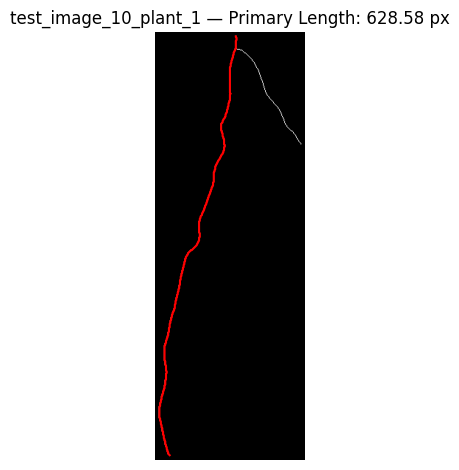

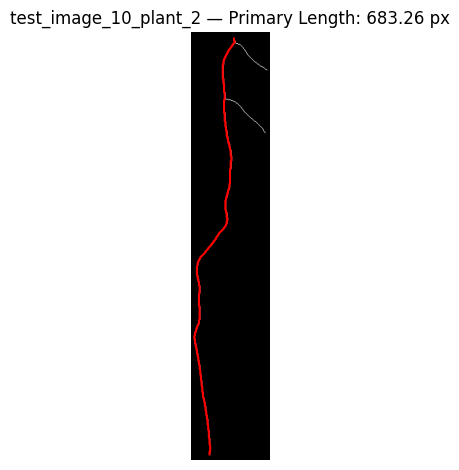

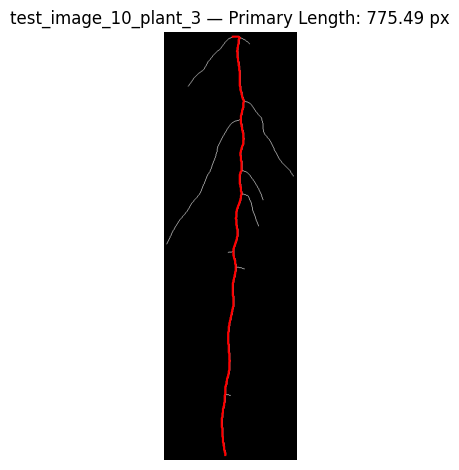

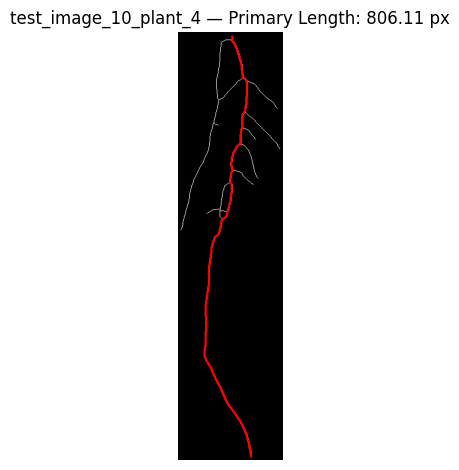

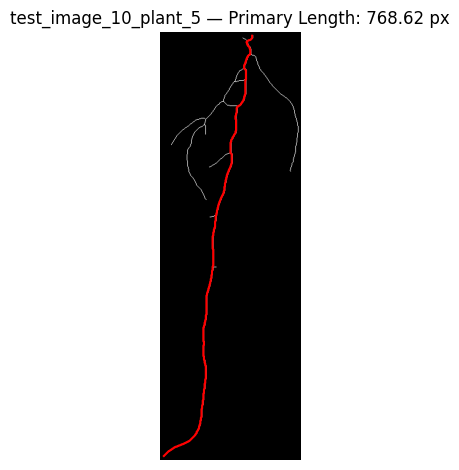

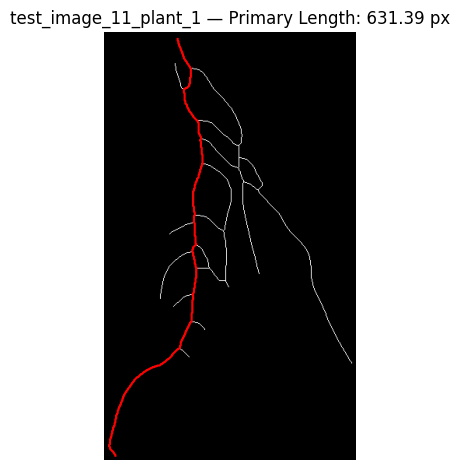

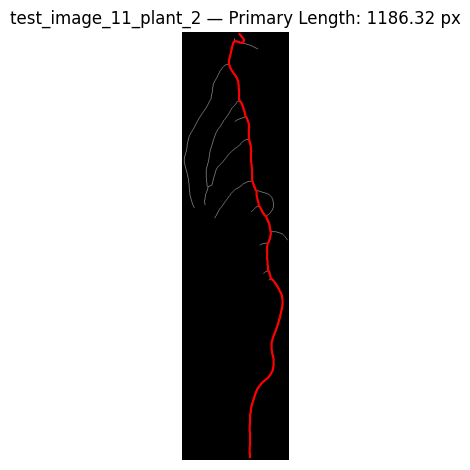

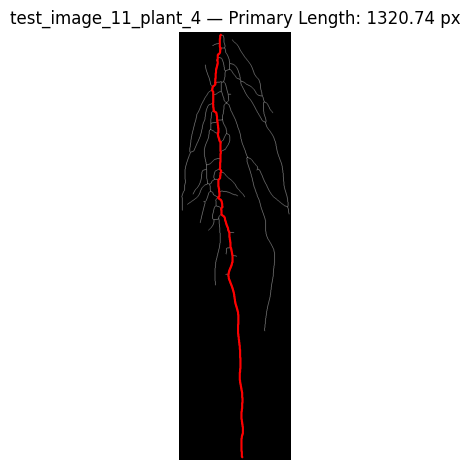

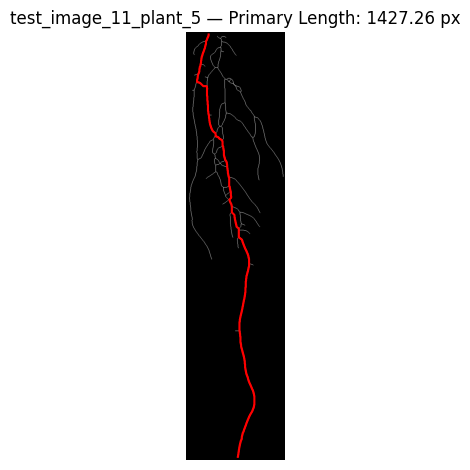

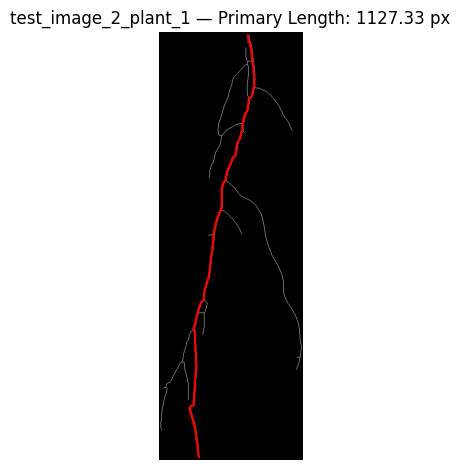

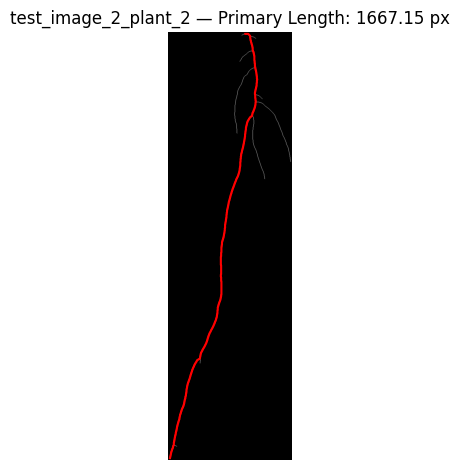

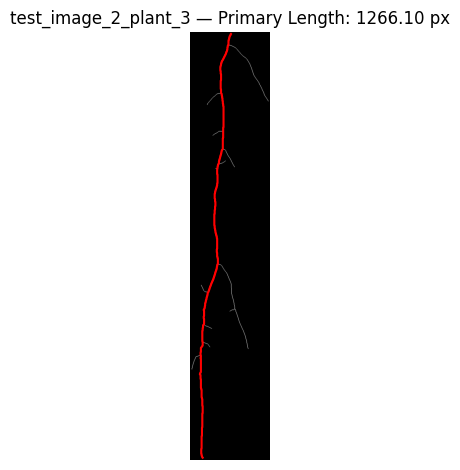

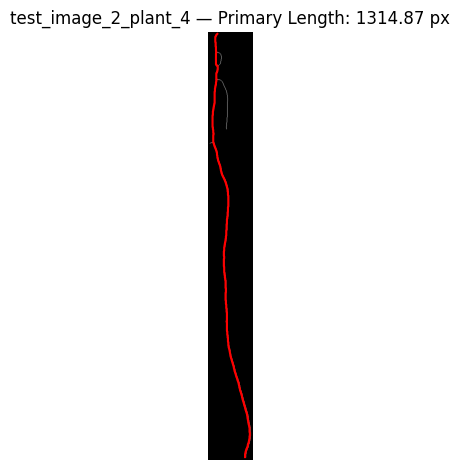

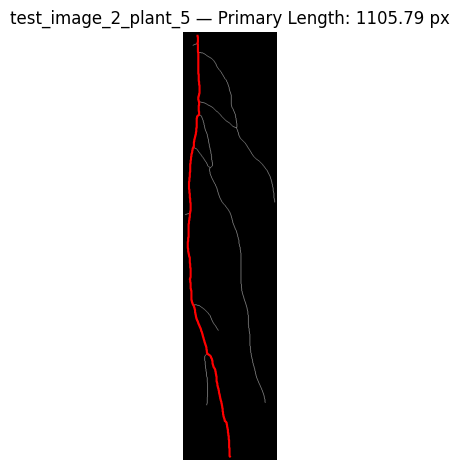

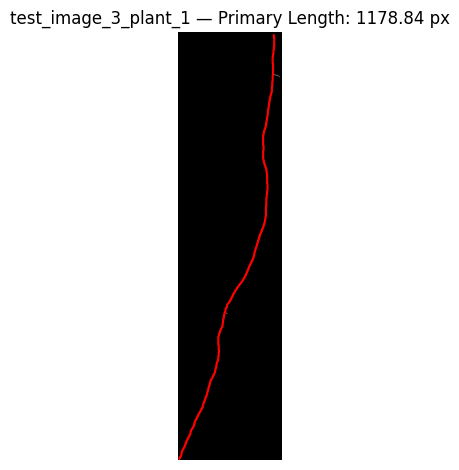

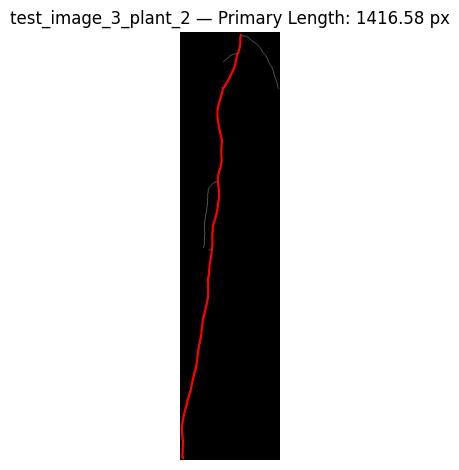

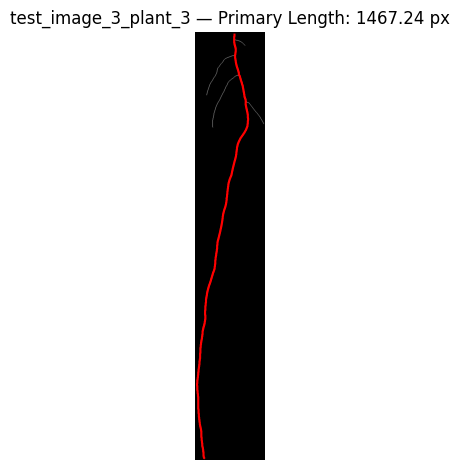

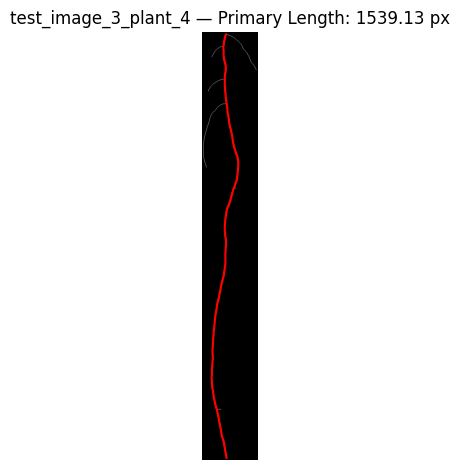

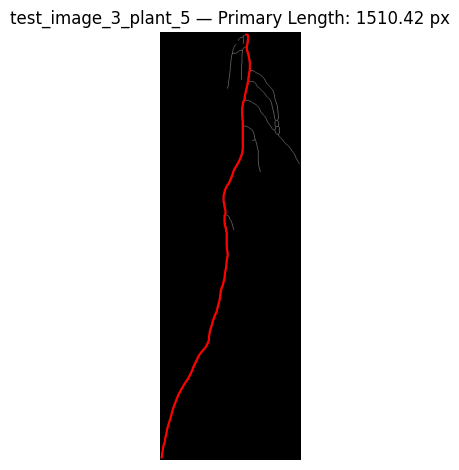

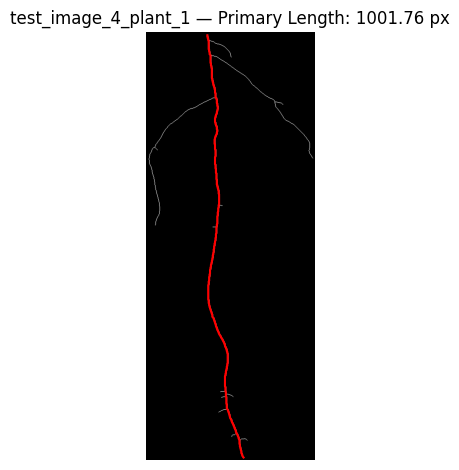

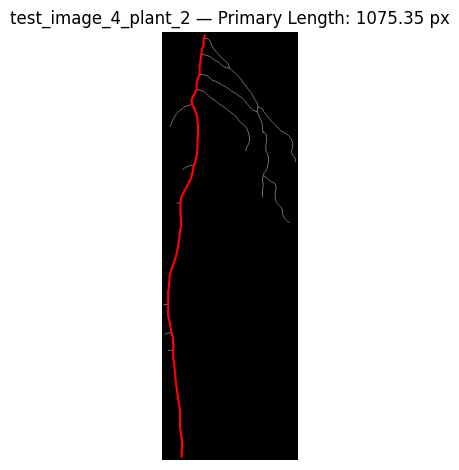

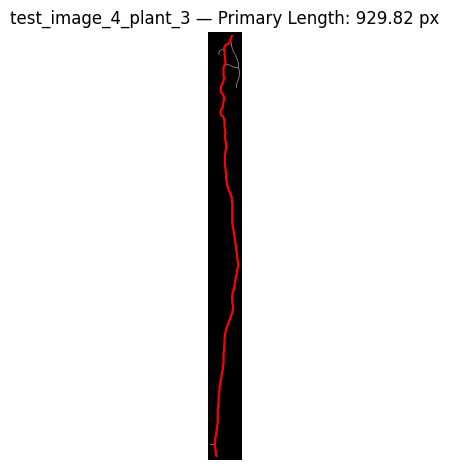

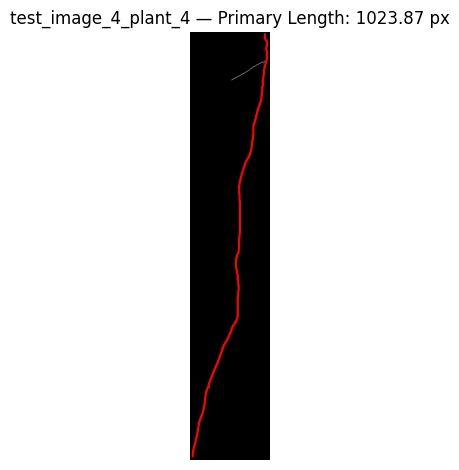

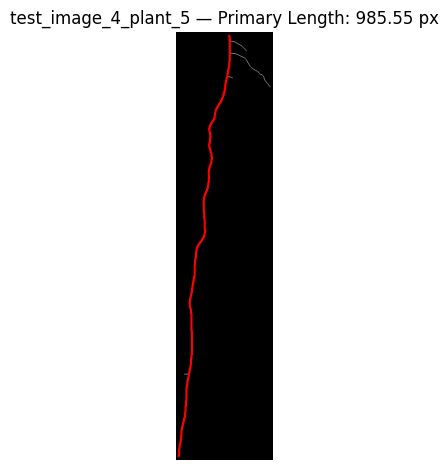

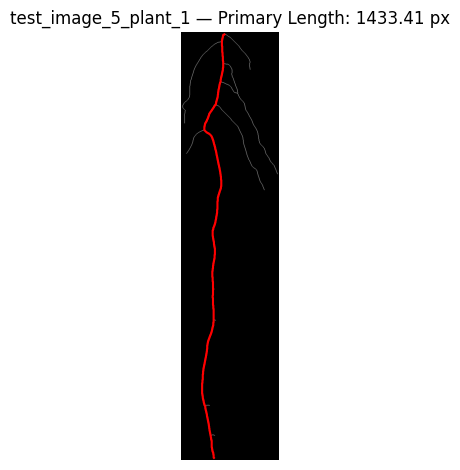

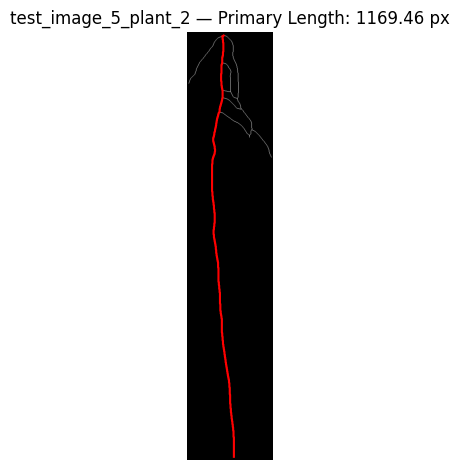

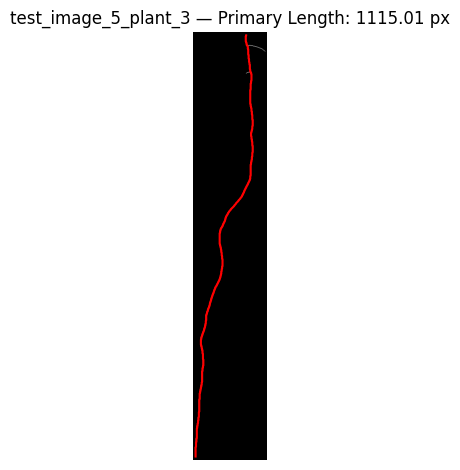

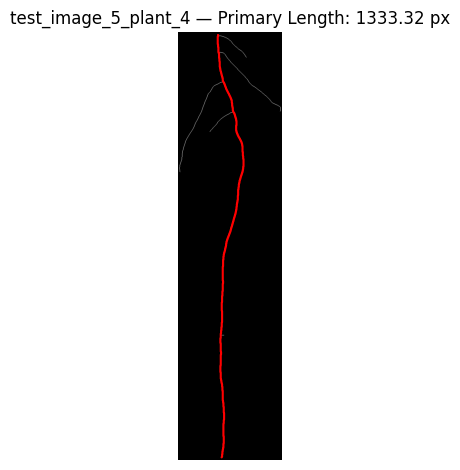

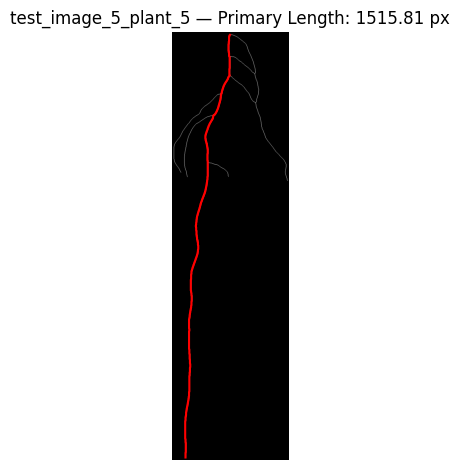

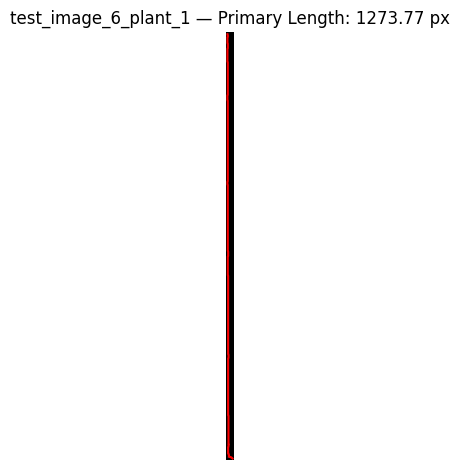

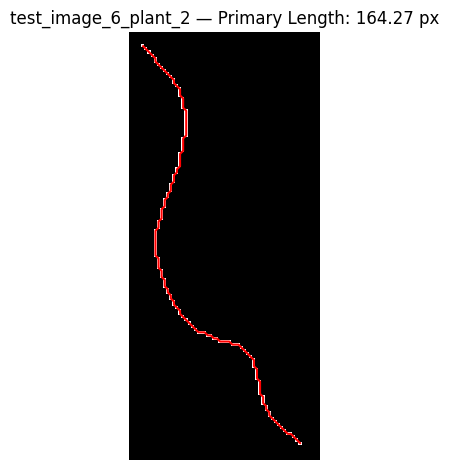

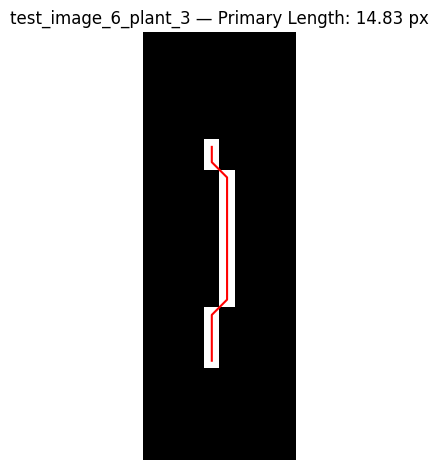

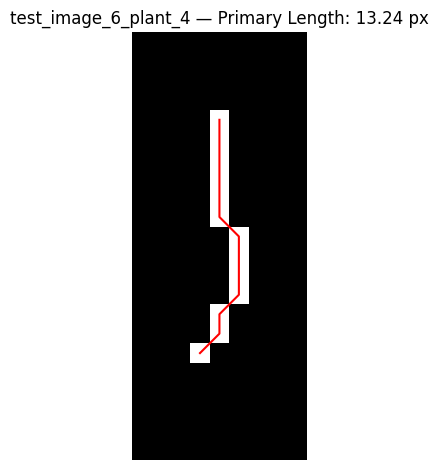

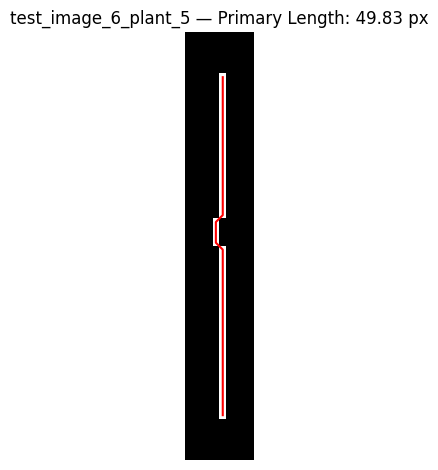

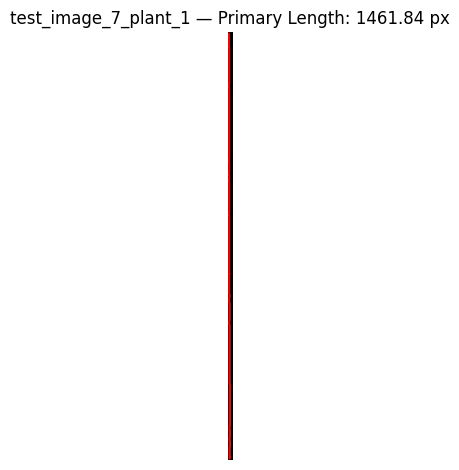

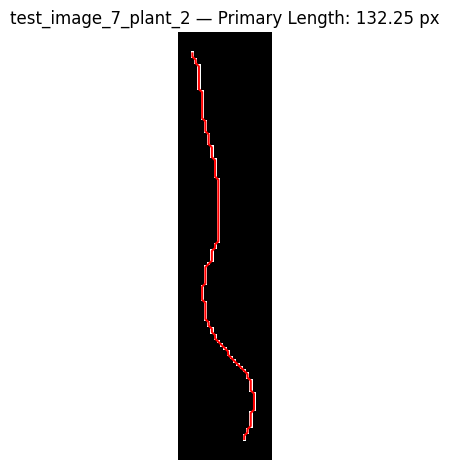

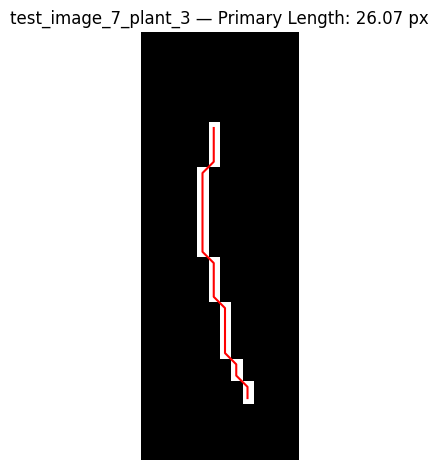

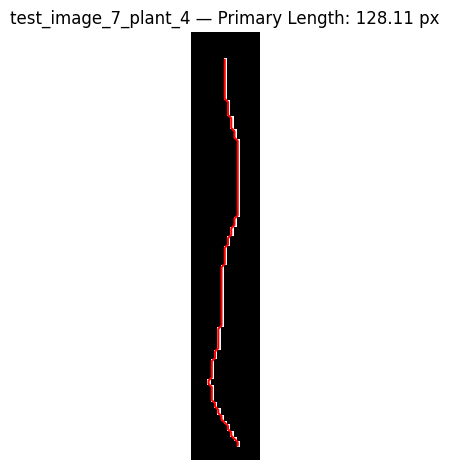

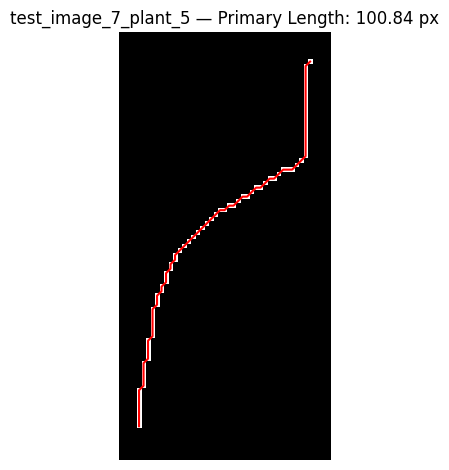

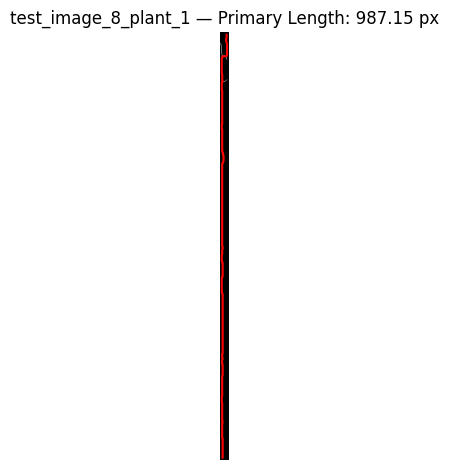

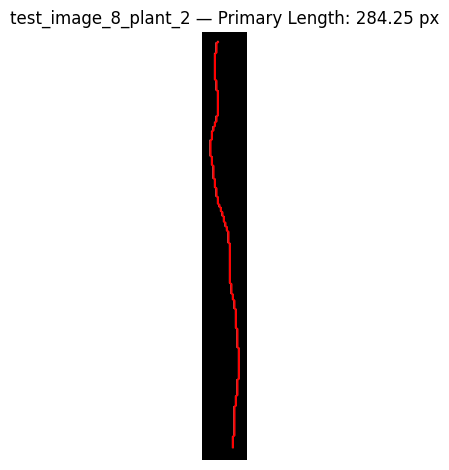

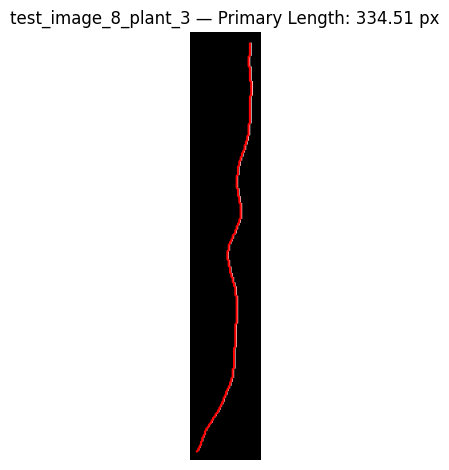

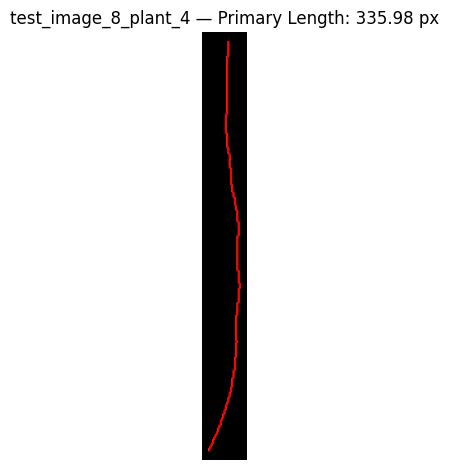

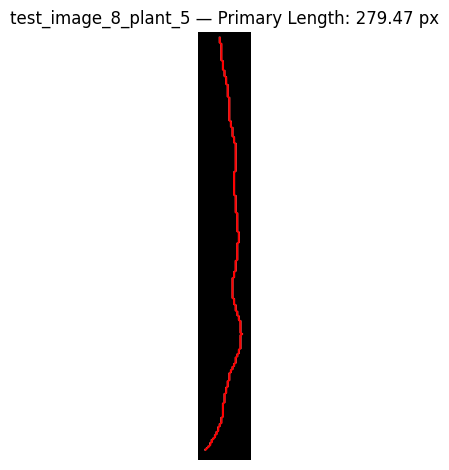

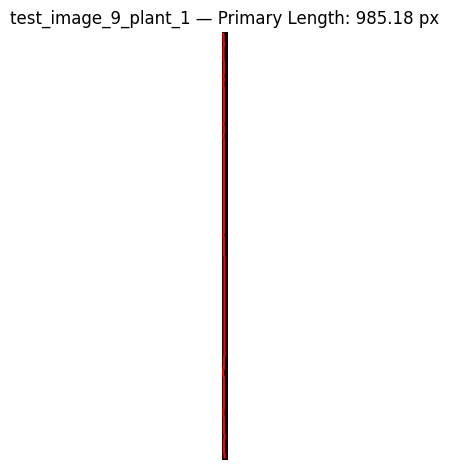

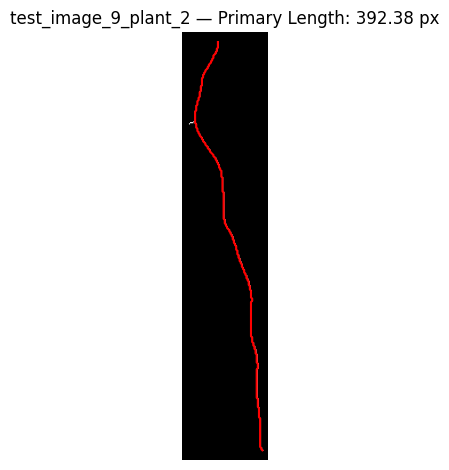

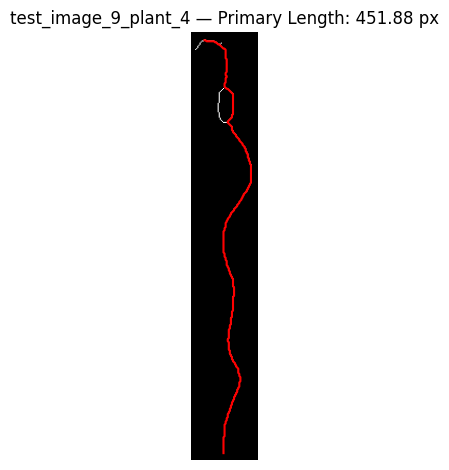

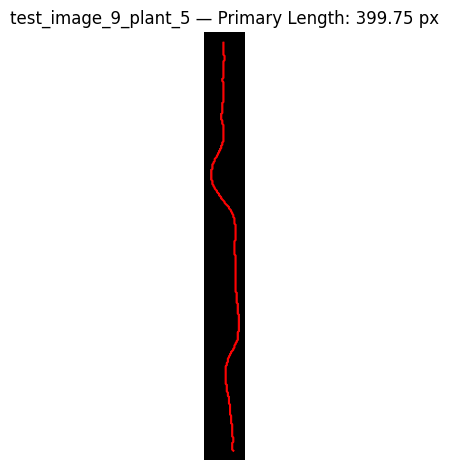

In [9]:

# Extract primary root length per plant 
primary_root_lengths = {}

for key, mask in final_root_masks.items():
    binary_mask = (mask > 0).astype(np.uint8)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)

    if num_labels <= 1:
        primary_root_lengths[key] = 0.00
        continue

    # Largest component assumed to be the primary root
    largest_component = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1
    component_mask = (labels == largest_component).astype(np.uint8)

    # Crop around bounding box
    x, y, w, h, _ = stats[largest_component]
    cropped_component = component_mask[y:y+h, x:x+w]

    # Optional pruning for robustness (small spurs)
    pruned = remove_small_objects(cropped_component.astype(bool), min_size=20)
    skeleton = skeletonize(pruned)

    # Build graph from skeleton pixels using Euclidean weights
    G = nx.Graph()
    skel_coords = np.argwhere(skeleton)
    coord_set = set(map(tuple, skel_coords))

    for y0, x0 in skel_coords:
        for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1),
                       (-1, -1), (-1, 1), (1, -1), (1, 1)]:
            neighbor = (y0 + dy, x0 + dx)
            if neighbor in coord_set:
                weight = np.hypot(dy, dx)
                G.add_edge((y0, x0), neighbor, weight=weight)

    if G.number_of_nodes() == 0:
        primary_root_lengths[key] = 0.00
        # still show skeleton 
        fig, ax = plt.subplots()
        ax.imshow(skeleton, cmap='gray')
        ax.text(0.5, 0.5, "No valid path", transform=ax.transAxes,
                ha='center', va='center', color='red')
        ax.set_title(f"{key} — Primary Length: 0.00 px")
        ax.axis('off'); plt.tight_layout(); plt.show()
        continue

    # Find topmost & bottommost nodes
    top_node = min(G.nodes, key=lambda n: n[0])
    bottom_node = max(G.nodes, key=lambda n: n[0])

    try:
        path = nx.dijkstra_path(G, source=top_node, target=bottom_node, weight='weight')
        path_length = nx.dijkstra_path_length(G, source=top_node, target=bottom_node, weight='weight')
    except nx.NetworkXNoPath:
        path = []
        path_length = 0.0

    primary_root_lengths[key] = round(path_length, 2)

    # Visualization
    fig, ax = plt.subplots()
    ax.imshow(skeleton, cmap='gray')
    if path:
        path_y, path_x = zip(*path)
        ax.plot(path_x, path_y, color='red', linewidth=1.5)
    else:
        ax.text(0.5, 0.5, "No valid path", transform=ax.transAxes,
                ha='center', va='center', color='red')
    ax.set_title(f"{key} — Primary Length: {primary_root_lengths[key]:.2f} px")
    ax.axis('off'); plt.tight_layout(); plt.show()


In [10]:
# Export predictions to CSV
Path(os.path.dirname(csv_path)).mkdir(parents=True, exist_ok=True)

with open(csv_path, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["Plant ID", "Length (px)"])
    for plant_id, length in primary_root_lengths.items():
        writer.writerow([plant_id, length])

print(f"Saved primary root lengths to:\n{csv_path}")


Saved primary root lengths to:
/Users/celinewu/Documents/GitHub/2024-25b-fai2-adsai-CelineWu231265/Retake/Submissions/sub15.csv
